# Assignment 1

#### imports

In [1]:
# for google colab
!pip install tqdm emoji gensim umap-learn rapidfuzz wordcloud nltk torchinfo --quiet
!pip install datasets transformers evaluate --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.4/608.4 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 34.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 68.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.5 MB/s eta 0:00:00


In [46]:
import copy, json, re, os, random
from collections import Counter
from typing import List, Callable, Dict
from collections import OrderedDict
import numpy as np
import pandas as pd
from tqdm import tqdm
import emoji
import gensim
from itertools import cycle
import gensim.downloader as gloader
import umap
import matplotlib.pyplot as plt
import seaborn as sns
from rapidfuzz import process, fuzz
from wordcloud import WordCloud
import gc

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import wordnet, stopwords

from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.manifold import TSNE

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.utils.rnn as rnn_utils
from torchinfo import summary
import torch.optim as optim
import torch.nn.functional as F

from datasets import Dataset
from evaluate import load

from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification, AutoConfig
from transformers import DataCollatorWithPadding
from transformers import TrainingArguments
from transformers import Trainer
from transformers import EarlyStoppingCallback

In [3]:
def fix_seed(seed: int):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
fix_seed(0)

seeds = [42, 1337, 2025]

In [4]:
nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('stopwords') # for google colab
nltk.download('punkt_tab')
nltk.download('punkt')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

## Google Drive

In [5]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [6]:
!cp -r "/content/drive/My Drive/Assignment_NLP/A1/data" /content/

## Task 1

In [41]:
def dataset_from_json(name):
    with open(name, 'r', encoding='utf-8') as f:
        data = json.load(f)
        df = pd.DataFrame.from_dict(data, orient='index')
        df = df[['id_EXIST', 'lang', 'tweet', 'labels_task2']]
        df = df.rename(columns={'labels_task2': 'label'})
        df = df[df['lang'] == 'en']

        def strict_majority_or_drop(arr):
            if not isinstance(arr, list) or len(arr) == 0:
                return None

            total_votes = len(arr)
            c = Counter(arr)
            most_common = c.most_common(1)

            if not most_common:
                return None

            top_label, top_count = most_common[0]

            if top_count > (total_votes / 2):
                return top_label
            else:
                return None

        df['label'] = df['label'].apply(strict_majority_or_drop)

        def map_label(label):
            mapping = {
                '-': 0,
                'DIRECT': 1,
                'JUDGEMENTAL': 2,
                'REPORTED': 3
            }
            return mapping.get(label, None)

        df = df.dropna(subset=['label'])
        df['label'] = df['label'].apply(map_label)

    return df

In [16]:
'''
def dataset_from_json(name):
    with open(name, 'r', encoding='utf-8') as f:
        data = json.load(f)
        df = pd.DataFrame.from_dict(data, orient='index')
        df = df[['id_EXIST', 'lang', 'tweet', 'labels_task2']]
        df = df.rename(columns={'labels_task2': 'label'})
        df = df[df['lang'] == 'en']

        def most_frequent_or_drop(arr):
            if not isinstance(arr, list):
                return arr
            c = Counter(arr)
            most_common = c.most_common()
            if len(most_common) == 0:
                return None
            max_count = most_common[0][1]
            candidates = [val for val,
                          count in most_common if count == max_count]
            if len(candidates) > 1:
                return None
            return candidates[0]

        df['label'] = df['label'].apply(most_frequent_or_drop)

        def map_label(label):
            mapping = {
                '-': 0,
                'DIRECT': 1,
                'JUDGEMENTAL': 2,
                'REPORTED': 3
            }
            return mapping.get(label, None)

        df = df.dropna(subset=['label'])
        df['label'] = df['label'].apply(map_label)

    return df
  '''

In [17]:
# non preprocessed datasets
train_df_np = dataset_from_json('data/training.json')
val_df_np = dataset_from_json('data/validation.json')
test_df_np = dataset_from_json('data/test.json')

train_df_np.head()

,id_EXIST,lang,tweet,label
200001,200001,en,FFS! How about laying the blame on the bastard...,0
200002,200002,en,Writing a uni essay in my local pub with a cof...,3
200003,200003,en,@UniversalORL it is 2021 not 1921. I dont appr...,3
200004,200004,en,@GMB this is unacceptable. Use her title as yo...,0
200005,200005,en,‘Making yourself a harder target’ basically bo...,0


### Dataset inspection

In [9]:
inspection_df = pd.DataFrame()
inspection_df = pd.concat([train_df_np, val_df_np, test_df_np], ignore_index=True)

# set the set attribute to train, val or test
inspection_df['split'] = ''
inspection_df.loc[:len(train_df_np)-1, 'split'] = 'train'
inspection_df.loc[len(train_df_np):len(train_df_np)+len(val_df_np)-1, 'split'] = 'val'
inspection_df.loc[len(train_df_np)+len(val_df_np):, 'split'] = 'test'

inspection_df.head()

,id_EXIST,lang,tweet,label,split
0,200001,en,FFS! How about laying the blame on the bastard...,0,train
1,200002,en,Writing a uni essay in my local pub with a cof...,3,train
2,200003,en,@UniversalORL it is 2021 not 1921. I dont appr...,3,train
3,200004,en,@GMB this is unacceptable. Use her title as yo...,0,train
4,200005,en,‘Making yourself a harder target’ basically bo...,0,train


#### Classes distribution

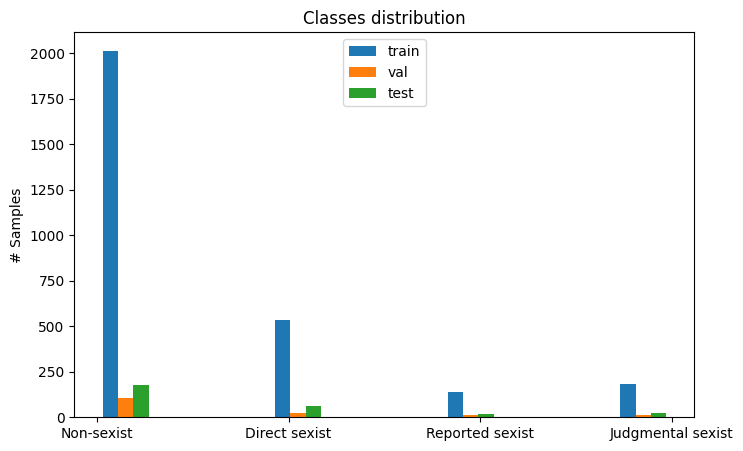

In [10]:
train_classes = inspection_df[inspection_df.split == 'train'].label.values
val_classes = inspection_df[inspection_df.split == 'val'].label.values
test_classes = inspection_df[inspection_df.split == 'test'].label.values

plt.figure(figsize=(8,5))
plt.hist([train_classes,val_classes,test_classes], bins=10, label=['train','val','test'], align="mid")
plt.xticks([0,1,2,3], ['Non-sexist', 'Direct sexist', 'Reported sexist', 'Judgmental sexist'])
plt.legend(loc='upper center')
plt.title('Classes distribution')
plt.ylabel('# Samples')
plt.show()

In [ ]:
# from sklearn.utils import resample

# def oversample_multiclass(df, target_col='label', random_state=101):
#     """Balance a multi-class dataset by oversampling minority classes."""
#     max_size = df[target_col].value_counts().max()

#     oversampled_parts = [
#         resample(df[df[target_col] == label],
#                  replace=True,
#                  n_samples=max_size,
#                  random_state=random_state)
#         for label in df[target_col].unique()
#     ]

#     df_oversampled = pd.concat(oversampled_parts)
#     return df_oversampled.sample(frac=1, random_state=random_state).reset_index(drop=True)

# oversampled_train_df = oversample_multiclass(train_df_np)

# train_df_np = oversampled_train_df

#### Tweet length distribution

100%|██████████| 280/280 [00:00<00:00, 660.35it/s]


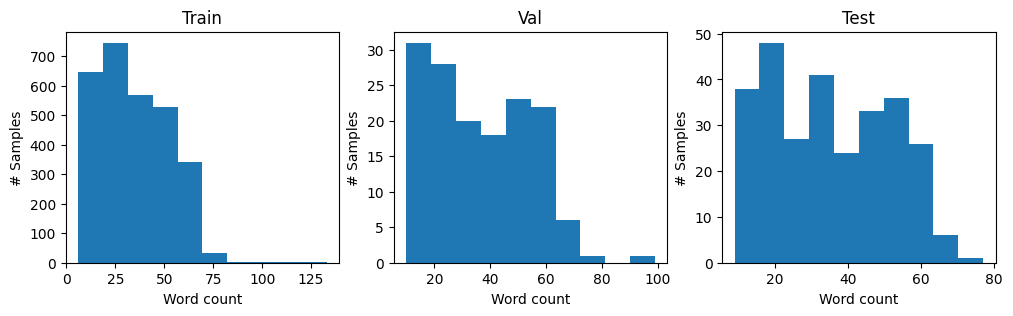

In [11]:
train_texts = inspection_df[inspection_df.split == 'train'].tweet.values
val_texts = inspection_df[inspection_df.split == 'val'].tweet.values
test_texts = inspection_df[inspection_df.split == 'test'].tweet.values

train_lengths = [len(word_tokenize(text)) for text in tqdm(train_texts)]
val_lengths = [len(word_tokenize(text)) for text in tqdm(val_texts)]
test_lengths = [len(word_tokenize(text)) for text in tqdm(test_texts)]

plt.figure(figsize=(12,3))
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.hist([train_lengths, val_lengths, test_lengths][i])
    plt.xlabel('Word count')
    plt.ylabel('# Samples')
    plt.title(['Train', 'Val', 'Test'][i])


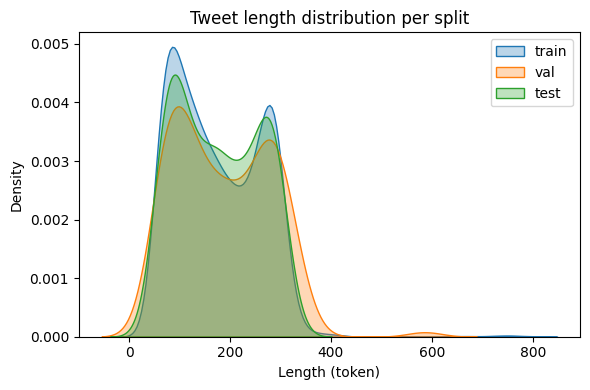

In [12]:
inspection_df["length"] = inspection_df["tweet"].apply(len)

plt.figure(figsize=(6,4))

for split in inspection_df["split"].unique():
    sns.kdeplot(
        inspection_df[inspection_df["split"] == split]["length"],
        label=split,
        fill=True,
        alpha=0.3
    )

plt.title("Tweet length distribution per split")
plt.xlabel("Length (token)")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()

#### Visualize the classes

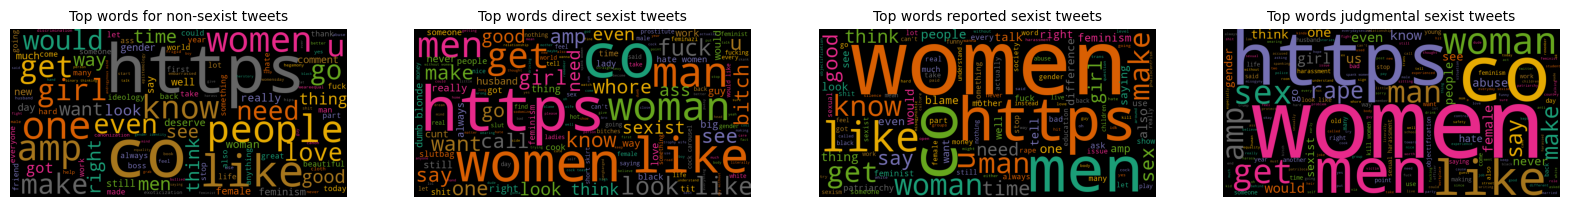

In [ ]:
n_posts = 1000
stop = set(stopwords.words('english'))
q_NS = ' '.join(inspection_df[inspection_df['label'] == 0]['tweet'].str.lower().values[:n_posts])
q_DS = ' '.join(inspection_df[inspection_df['label'] == 1]['tweet'].str.lower().values[:n_posts])
q_RS = ' '.join(inspection_df[inspection_df['label'] == 2]['tweet'].str.lower().values[:n_posts])
q_JS = ' '.join(inspection_df[inspection_df['label'] == 3]['tweet'].str.lower().values[:n_posts])

wordcloud_NS = WordCloud(max_font_size=None, stopwords=stop,scale = 2,colormap = 'Dark2').generate(q_NS)
wordcloud_DS = WordCloud(max_font_size=None, stopwords=stop,scale = 2,colormap = 'Dark2').generate(q_DS)
wordcloud_RS = WordCloud(max_font_size=None, stopwords=stop,scale = 2,colormap = 'Dark2').generate(q_RS)
wordcloud_JS = WordCloud(max_font_size=None, stopwords=stop,scale = 2,colormap = 'Dark2').generate(q_JS)

fig, ax = plt.subplots(1,4, figsize=(20, 5))
ax[0].imshow(wordcloud_NS)
ax[0].set_title('Top words for non-sexist tweets',fontsize = 10)
ax[0].axis("off")

ax[1].imshow(wordcloud_DS)
ax[1].set_title('Top words direct sexist tweets',fontsize = 10)
ax[1].axis("off")

ax[2].imshow(wordcloud_RS)
ax[2].set_title('Top words reported sexist tweets',fontsize = 10)
ax[2].axis("off")

ax[3].imshow(wordcloud_JS)
ax[3].set_title('Top words judgmental sexist tweets',fontsize = 10)
ax[3].axis("off")

plt.show()

## Task 2

In [ ]:
stop_words = set(stopwords.words('english'))  # enhlish stopwords set

def clean_text(text: str) -> str:
    """Remove emojis, URLs, mentions, hashtags, special characters, extra spaces, and stopwords."""
    text = text.lower()
    text = emoji.replace_emoji(text, replace='')  # remove emojis
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'@\w+|#\w+', '', text)  # remove mentions and hashtags
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # remove special characters
    text = re.sub(r'\s+', ' ', text)  # remove extra spaces
    text = re.sub(r'["\'`\’\‘\“\”]', ' ', text)  # remove extra quotes

    # remove stopwords
    words = text.split()
    words = [w for w in words if w not in stop_words]
    return ' '.join(words).strip()

def lemmatize_text(text: str) -> str:
    """Lemmatize text using POS tagging for more accurate results."""
    lemmatizer = WordNetLemmatizer()

    def get_wordnet_pos(tag):
        if tag.startswith('J'):
            return wordnet.ADJ
        elif tag.startswith('V'):
            return wordnet.VERB
        elif tag.startswith('N'):
            return wordnet.NOUN
        elif tag.startswith('R'):
            return wordnet.ADV
        else:
            return wordnet.NOUN

    words = text.split()
    pos_tags = pos_tag(words)
    lemmatized_words = [lemmatizer.lemmatize(word, get_wordnet_pos(tag)) for word, tag in pos_tags]
    return ' '.join(lemmatized_words)

def text_preprocessing(df, column='tweet', pipeline=None):
    """
    Apply a sequence of preprocessing functions to a dataframe column.

    Parameters:
    - df: pandas DataFrame
    - column: name of the text column
    - pipeline: list of functions to apply sequentially
    """
    df = df.copy()
    if pipeline is None:
        pipeline = [clean_text, lemmatize_text]

    for func in pipeline:
        df[column] = df[column].apply(func)

    return df

In [ ]:
pipeline = [clean_text, lemmatize_text]

train_df = text_preprocessing(train_df_np, pipeline=pipeline)
val_df = text_preprocessing(val_df_np, pipeline=pipeline)
test_df = text_preprocessing(test_df_np, pipeline=pipeline)

In [ ]:
train_df.head()

,id_EXIST,lang,tweet,label
0,201087,en,post definitely fake lmfao woman cant force la...,1
1,201753,en,youd know good whose metanarrative found convi...,0
2,201234,en,yes want beautiful black wife love get gangban...,1
3,201045,en,cw weird fashy shitmy grandma lent american fa...,2
4,200139,en,tw pedophiliajust story chalk event last weeks...,3


### Dataset inspection

In [ ]:
inspection_df = pd.DataFrame()
inspection_df = pd.concat([train_df_np, val_df_np, test_df_np], ignore_index=True)

# set the set attribute to train, val or test
inspection_df['split'] = ''
inspection_df.loc[:len(train_df_np)-1, 'split'] = 'train'
inspection_df.loc[len(train_df_np):len(train_df_np)+len(val_df_np)-1, 'split'] = 'val'
inspection_df.loc[len(train_df_np)+len(val_df_np):, 'split'] = 'test'

inspection_df.head()

,id_EXIST,lang,tweet,label,split
0,201087,en,@___inCANdescent @_sutoretchi This post is def...,1,train
1,201753,en,"@demoormj You'd know better than me, this is j...",0,train
2,201234,en,@IaintNOmuggleHO @hotebonynicole YES! All I wa...,1,train
3,201045,en,CW Weird fashy shitMy grandma lent me this (am...,2,train
4,200139,en,TW /////// PedophiliaJust a few of the stories...,3,train


#### Token distribution

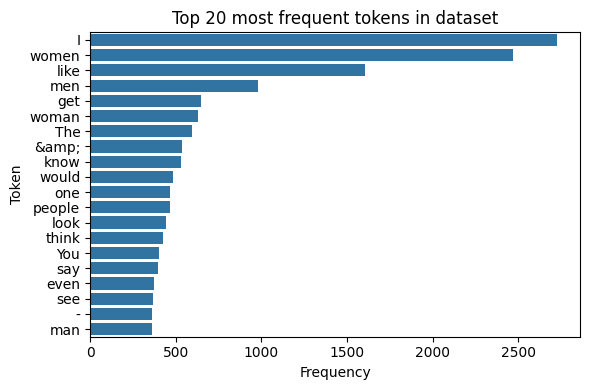

In [ ]:
inspection_df["tokens"] = inspection_df["tweet"].apply(lambda x: [t for t in x.split() if t not in stop_words])
all_tokens = [token for sublist in inspection_df["tokens"] for token in sublist]
freq_dist = Counter(all_tokens).most_common(20)   # top 20 tokens

tokens, counts = zip(*freq_dist)

plt.figure(figsize=(6,4))
sns.barplot(x=list(counts), y=list(tokens))
plt.title("Top 20 most frequent tokens in dataset")
plt.xlabel("Frequency")
plt.ylabel("Token")
plt.tight_layout()
plt.show()

## Task 3

### Build the vocabulary

In [ ]:
def build_vocabulary(
    df: pd.DataFrame,
    column_name: str = "tweet",
    add_special_tokens: bool = True
):
    """
    Builds a complete vocabulary from a DataFrame column.
    Returns mappings (idx_to_word, word_to_idx), word listing, and frequency DataFrame.

    Parameters:
    - df: DataFrame containing the text column.
    - column_name: Name of the column to process.
    - add_special_tokens: Whether to include <PAD> and <UNK> tokens.
    Returns:
    - idx_to_word (OrderedDict[int, str])
    - word_to_idx (OrderedDict[str, int])
    - word_listing (List[str])
    - vocab_df (pd.DataFrame with 'vocabulary' and 'counts')
    """

    # Builds a list tokens from the tweets
    text_array = df[column_name].values
    list_of_token_lists = [t.split() for t in text_array]
    repeated_vocab = np.concatenate(list_of_token_lists)
    repeated_vocab = repeated_vocab[repeated_vocab != ""]  # removes empty strings

    # Counts the frequency of each word
    token_array, counts_array = np.unique(repeated_vocab, return_counts=True)

    # Sorts by descending frequency
    sorted_indices = np.argsort(-counts_array)
    token_array = token_array[sorted_indices].tolist()
    counts_array = counts_array[sorted_indices]

    # Creates ordered mappings
    idx_to_word = OrderedDict()
    word_to_idx = OrderedDict()
    curr_idx = 0

    if add_special_tokens:
        for tok in ["<PAD>", "<UNK>"]:
            word_to_idx[tok] = curr_idx
            idx_to_word[curr_idx] = tok
            curr_idx += 1

    for token in tqdm(token_array, desc="Building vocabulary"):
        word_to_idx[token] = curr_idx
        idx_to_word[curr_idx] = token
        curr_idx += 1

    # Builds word listing and DataFrame
    word_listing = list(idx_to_word.values())
    vocab_df = pd.DataFrame({"vocabulary": token_array, "counts": counts_array})

    return idx_to_word, word_to_idx, word_listing, vocab_df

In [ ]:
idx_to_word, word_to_idx, word_listing, vocab_df = build_vocabulary(train_df)

print("Size:", len(word_to_idx))
print("Most common words:\n", vocab_df.head(10))
print("Example mapping:", list(word_to_idx.items())[:10])

Building vocabulary: 100%|██████████| 7573/7573 [00:00<00:00, 2187566.40it/s]

Size: 7575
Most common words:
   vocabulary  counts
0      woman    4025
1       like    1713
2        men    1303
3       dont    1089
4        get    1082
5        say    1062
6       make     786
7         go     683
8       know     644
9        man     612
Example mapping: [('<PAD>', 0), ('<UNK>', 1), ('woman', 2), ('like', 3), ('men', 4), ('dont', 5), ('get', 6), ('say', 7), ('make', 8), ('go', 9)]


#### Evaluate the vocabulary

In [ ]:
def evaluate_vocabulary(
    idx_to_word: Dict[int, str],
    word_to_idx: Dict[str, int],
    word_listing: List[str],
    df: pd.DataFrame,
    check_default_size: bool = False
):
    assert len(idx_to_word) == len(word_to_idx)
    assert len(idx_to_word) == len(word_listing)

    for i in tqdm(range(0, len(idx_to_word))):
        assert idx_to_word[i] in word_to_idx
        assert word_to_idx[idx_to_word[i]] == i

    _, _, first_word_listing, _ = build_vocabulary(df)
    _, _, second_word_listing, _ = build_vocabulary(df)
    assert first_word_listing == second_word_listing

In [ ]:
print("Vocabulary evaluation...")
evaluate_vocabulary(idx_to_word, word_to_idx, word_listing, train_df)
print("")
print("Evaluation completed!")

Vocabulary evaluation...


Building vocabulary: 100%|██████████| 7573/7573 [00:00<00:00, 2379820.50it/s]


Evaluation completed!


#### Save the vocabulary

In [ ]:
vocab_path = './data/vocab.json'

print(f"Saving vocabulary to {vocab_path}")
with open(vocab_path, mode='w') as f:
    json.dump(word_to_idx, f, indent=4)
print("Saving completed!")

Saving vocabulary to ./data/vocab.json
Saving completed!


### OOV words

In [ ]:
embedding_dimension = 50
download_path = "glove-wiki-gigaword-{}".format(embedding_dimension)
embedding_model = gloader.load(download_path)

In [ ]:
def check_OOV_terms(embedding_model: gensim.models.keyedvectors.KeyedVectors,
                    word_listing: List[str]):
    """
    Checks differences between pre-trained embedding model vocabulary
    and dataset specific vocabulary in order to highlight out-of-vocabulary terms.

    Parameters:
    - embedding_model: pre-trained word embedding model (gensim wrapper)
    - word_listing: dataset specific vocabulary (list)
    Returns:
        - list of OOV terms
    """
    embedding_vocabulary = set(embedding_model.key_to_index.keys())
    oov = set(word_listing).difference(embedding_vocabulary)
    return list(oov)

In [ ]:
oov_terms = check_OOV_terms(embedding_model, word_listing)
oov_percentage = float(len(oov_terms)) * 100 / len(word_listing)
print(f"Total OOV terms: {len(oov_terms)} ({oov_percentage:.2f}%)")
print(oov_terms[:3])

Total OOV terms: 1242 (16.40%)
['piespeaking', 'manipulativethere', 'pornhub']


### Embedding

In [ ]:
def embedding_from_context(train_df, word, embedding_matrix, context_size=3, embedding_dimension=50):
    """Generate an embedding for an oov word as average of its context in the training data."""
    try:
        for seq in train_df.tweet.values:
            tokens = seq.split()
            if word in tokens:
                pos = tokens.index(word)
                start = max(0, pos - context_size)
                end = min(len(tokens), pos + context_size + 1)
                context_words = [t for t in tokens[start:end] if t != word]
                break
        context_embeddings = []
        for context_word in context_words:
            try:
                context_embeddings.append(embedding_matrix[word_to_idx[context_word]])
            except KeyError:
                # if the context word is also oov, skip it
                continue
        if not len(context_embeddings) > 2:
            raise ValueError("Not enough context embeddings found")

        embedding = np.mean(context_embeddings, axis=0)
    except Exception as e:
        embedding = np.random.uniform(low=-3, high=3, size=embedding_dimension)
    return embedding

def embedding_as_subwords(word, glove, n=3):
    """Generate an embedding for an oov word as average of its subwords."""
    subwords = [word[i:i+n] for i in range(len(word)-n+1)]
    known_subs = [glove[sub] for sub in subwords if sub in glove]
    if known_subs:
        return np.mean(known_subs, axis=0)
    else:
        return np.mean(glove.vectors, axis=0)  # fallback: average vector

def embedding_from_similarity(word, glove, scorer='ratio', top_k=1, min_score=70):
    """Generate an embedding for an oov word as average of its neighbors in the embedding space."""
    vocab_list = glove.index_to_key
    scorer_fn = getattr(fuzz, scorer)
    # Find top_k closest matches by fuzzy similarity
    matches = process.extract(word, vocab_list, limit=top_k, scorer=scorer_fn)
    # Filter out low-similarity matches
    valid_matches = [(w, s) for w, s, _ in matches if s >= min_score]

    if not valid_matches:
        return np.mean(glove.vectors, axis=0)

    # Weighted average of matched embeddings by similarity score
    vectors, weights = [], []
    for w, score in valid_matches:
        vectors.append(glove[w])
        weights.append(score)

    weights = np.array(weights) / np.sum(weights)
    return np.average(vectors, axis=0, weights=weights)

In [ ]:
def build_embedding_matrix(
    embedding_model,
    embedding_dimension: int,
    word_to_idx: Dict[str, int],
    vocab_size: int,
    oov_terms: List[str] = None,
    unk_token: str = "<UNK>",
    oov_strategy: str = "random",
    random_seed: int = 42
) -> torch.Tensor:
    """
    Builds an embedding matrix for a dataset, handling OOV and <UNK> tokens.
    Parameters:
    - embedding_model: pre-trained word embeddings (GloVe)
    - embedding_dimension: dimensionality of embeddings
    - word_to_idx: dictionary mapping words to indices
    - vocab_size: total vocabulary size
    - oov_terms: list of OOV terms from training set
    - unk_token: token used for unseen words in val/test
    - random_seed: for reproducibility of random embeddings
    Returns: embedding matrix (torch.Tensor) of shape [vocab_size, embedding_dimension]
    """
    np.random.seed(random_seed)
    embedding_matrix = np.zeros((vocab_size, embedding_dimension), dtype=np.float32)

    # Precompute a random vector for <UNK>
    unk_vector = np.random.uniform(-0.05, 0.05, embedding_dimension).astype(np.float32)

    for word, idx in tqdm(word_to_idx.items(), desc="Building embedding matrix"):
        if word == unk_token:
            embedding_matrix[idx] = unk_vector
        else:
            try:
                embedding_vector = embedding_model[word]
            except KeyError:
                # OOV word
                if oov_strategy == "context":
                    embedding_vector = embedding_from_context(train_df, word, embedding_matrix, context_size=5)
                elif oov_strategy == "mean":
                    mean_embedding = np.mean(embedding_matrix, axis=0)
                    noise = np.random.normal(0, 1, mean_embedding.shape)
                    embedding_vector = mean_embedding + noise
                elif oov_strategy == "subwords" and embedding_model is not None:
                    embedding_vector = embedding_as_subwords(word, embedding_model, n=3)
                elif oov_strategy == "similarity" and embedding_model is not None:
                    embedding_vector = embedding_from_similarity(word, embedding_model, top_k=3)
                else:   # oov_strategy == "random"
                    embedding_vector = np.random.uniform(-0.05, 0.05, embedding_dimension).astype(np.float32)

            embedding_matrix[idx] = embedding_vector

    embedding_matrix = torch.tensor(embedding_matrix, dtype=torch.float32)
    return embedding_matrix

In [ ]:
vocab_size = len(word_to_idx)

embedding_matrix = build_embedding_matrix(
    embedding_model=embedding_model,
    embedding_dimension=embedding_dimension,
    word_to_idx=word_to_idx,
    vocab_size=vocab_size,
    oov_terms=oov_terms,
    unk_token="<UNK>",
    oov_strategy="subwords",
)

print()
print(embedding_matrix.shape)  # [vocab_size, embedding_dim]

Building embedding matrix: 100%|██████████| 7575/7575 [00:00<00:00, 32950.32it/s]



torch.Size([7575, 50])


In [ ]:
def co_occurrence_count(df: pd.DataFrame,
                        idx_to_word: Dict[int, str],
                        word_to_idx: Dict[str, int],
                        window_size: int = 4) -> np.ndarray:
    """
    Builds word-word co-occurrence matrix based on word counts.
    Parameters:
    - df: DataFrame containing the text column.
    - idx_to_word: mapping from indices to words.
    - word_to_idx: mapping from words to indices.
    - window_size: size of the context window.
    Returns: co_occurrence symmetric matrix of size |V| x |V|
    """
    vocab_size = len(idx_to_word)
    co_occurrence_matrix = np.zeros((vocab_size, vocab_size),
                                    dtype=np.float32)
    for sentence in tqdm(df.tweet.values):
        tokens = sentence.split()
        for pos, token in enumerate(tokens):
            start = max(0, pos - window_size)
            end = min(pos + window_size + 1, len(tokens))

            first_word_index = word_to_idx[token]
            for pos2 in range(start, end):
                if pos2 != pos:
                    second_token = tokens[pos2]
                    second_word_index = word_to_idx[second_token]
                    co_occurrence_matrix[first_word_index,
                                         second_word_index] += 1
    return co_occurrence_matrix

In [ ]:
co_occurrence_matrix = co_occurrence_count(train_df,
                                           idx_to_word,
                                           word_to_idx,
                                           window_size=4)

100%|██████████| 8056/8056 [00:00<00:00, 11507.52it/s]


### Embedding Visualization

In [ ]:
def visualize_embeddings(embeddings: np.ndarray,
                         word_annotations: List[str] = None,
                         word_to_idx: Dict[str, int] = None):
    """
    Plots given reduce word embeddings (2D). Users can highlight specific words (word_annotations list).

    Parameters:
    - embeddings: word embedding matrix of shape (words, 2) retrieved via a dimensionality reduction technique.
    - word_annotations: list of words to be annotated.
    - word_to_idx: vocabulary map (word -> index) (dict)
    """
    fig, ax = plt.subplots(1, 1, figsize=(4, 3))

    if word_annotations:
        print(f"Annotating words: {word_annotations}")

        word_indexes = []
        for word in word_annotations:
            word_index = word_to_idx[word]
            word_indexes.append(word_index)

        word_indexes = np.array(word_indexes)

        other_embeddings = embeddings[np.setdiff1d(np.arange(embeddings.shape[0]), word_indexes)]
        target_embeddings = embeddings[word_indexes]

        ax.scatter(other_embeddings[:, 0], other_embeddings[:, 1], alpha=0.1, c='blue')
        ax.scatter(target_embeddings[:, 0], target_embeddings[:, 1], alpha=1.0, c='red')
        ax.scatter(target_embeddings[:, 0], target_embeddings[:, 1], alpha=1, facecolors='none', edgecolors='r', s=1000)

        for word, word_index in zip(word_annotations, word_indexes):
            word_x, word_y = embeddings[word_index, 0], embeddings[word_index, 1]
            ax.annotate(word, xy=(word_x, word_y))
    else:
        ax.scatter(embeddings[:, 0], embeddings[:, 1], alpha=0.1, c='blue')

    # We avoid outliers ruining the visualization if they are quite far away
    axis_x_limit = (np.min(embeddings[:, 0]), np.max(embeddings[:, 0]))
    axis_y_limit = (np.min(embeddings[:, 1]), np.max(embeddings[:, 1]))
    plt.xlim(left=axis_x_limit[0] - 0.5, right=axis_x_limit[1] + 0.5)
    plt.ylim(bottom=axis_y_limit[0] - 0.5, top=axis_y_limit[1] + 0.5)
    ax.set_xlim(axis_x_limit[0], axis_x_limit[1])
    ax.set_ylim(axis_y_limit[0], axis_y_limit[1])
    plt.show()

In [ ]:
def reduce_SVD(embeddings: np.ndarray) -> np.ndarray:
    """
    Applies SVD dimensionality reduction.

    Parameters:
    - embeddings: word embedding matrix of shape (words, dim). In the case
                       of a word-word co-occurrence matrix the matrix shape would
                       be (words, words).

    Returns:
        - 2-dimensional word embedding matrix of shape (words, 2)
    """
    svd = TruncatedSVD(n_components=2, n_iter=10)
    reduced = svd.fit_transform(embeddings)

    return reduced

def reduce_umap(embeddings: np.ndarray) -> np.ndarray:
    """
    Applies UMAP dimensionality reduction.

    Parameters:
    - embeddings: word embedding matrix of shape (words, dim). In the case
                       of a word-word co-occurrence matrix the matrix shape would
                       be (words, words).
    Returns:
        - 2-dimensional word embedding matrix of shape (words, 2)
    """
    umap_emb = umap.UMAP(n_components=2, metric='cosine')
    reduced = umap_emb.fit_transform(embeddings)

    return reduced

In [ ]:
def run_visualization(method_name: str,
                      words_list: List[str],
                      word_to_idx: Dict[str, int],
                      co_occurrence_matrix):
    method_name = method_name.lower().strip()
    method_map = {
        'svd': reduce_SVD,
        'umap': reduce_umap
    }

    if method_name not in method_map:
        raise RuntimeError(f'Invalid method name! Got {method_name}.')

    reduced = method_map[method_name](co_occurrence_matrix)
    visualize_embeddings(reduced, words_list, word_to_idx)

Annotating words: ['leftover', 'celebration', 'creatives']


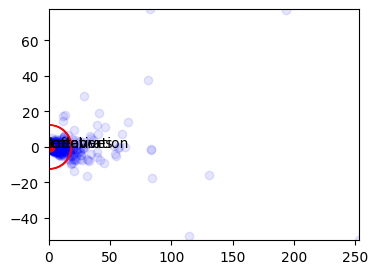

In [ ]:
rand_words = np.random.choice(list(word_to_idx.keys()), size=3, replace=False).tolist()
run_visualization('svd',rand_words, word_to_idx, co_occurrence_matrix)

Annotating words: ['leftover', 'celebration', 'creatives']


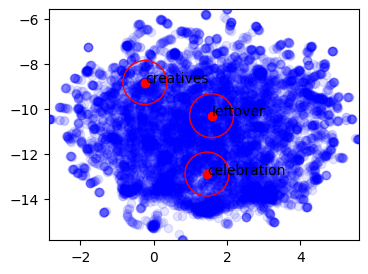

In [ ]:
run_visualization('umap',rand_words, word_to_idx, co_occurrence_matrix)

### Test all oov embedding strategies


Building embedding matrix with OOV strategy: random


100%|██████████| 2873/2873 [00:00<00:00, 12052.14it/s]


Annotating words: ['prostitutionwow', 'consume', 'trojan']


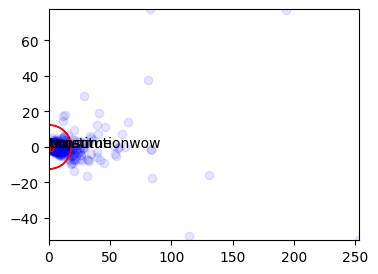

Annotating words: ['prostitutionwow', 'consume', 'trojan']


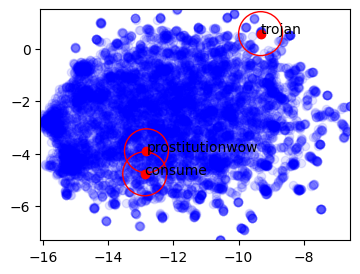


Building embedding matrix with OOV strategy: context


100%|██████████| 2873/2873 [00:00<00:00, 13424.04it/s]


Annotating words: ['sympathy', 'chefayo', 'ref']


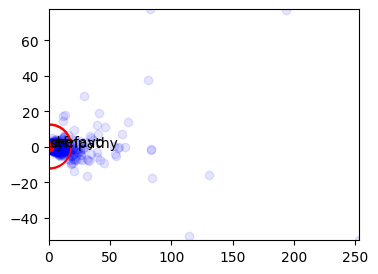

Annotating words: ['sympathy', 'chefayo', 'ref']


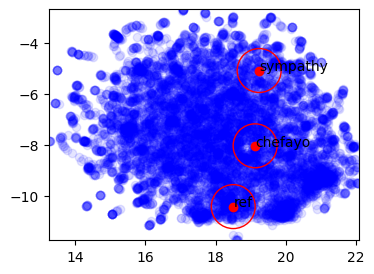


Building embedding matrix with OOV strategy: mean


100%|██████████| 2873/2873 [00:00<00:00, 12682.16it/s]


Annotating words: ['agender', 'best', 'scripture']


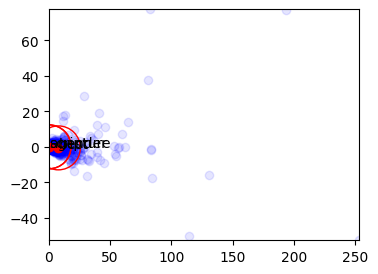

Annotating words: ['agender', 'best', 'scripture']


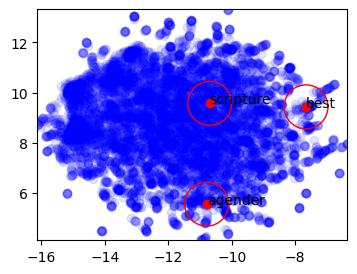


Building embedding matrix with OOV strategy: subwords


100%|██████████| 2873/2873 [00:00<00:00, 11203.78it/s]


Annotating words: ['leftover', 'celebration', 'creatives']


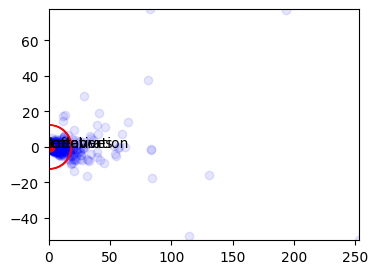

Annotating words: ['leftover', 'celebration', 'creatives']


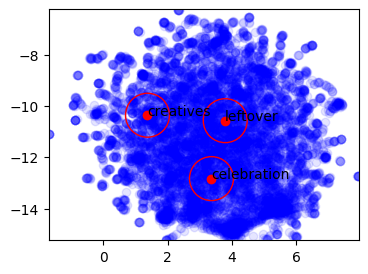


Building embedding matrix with OOV strategy: similarity


100%|██████████| 2873/2873 [00:00<00:00, 11886.29it/s]


Annotating words: ['leftover', 'celebration', 'creatives']


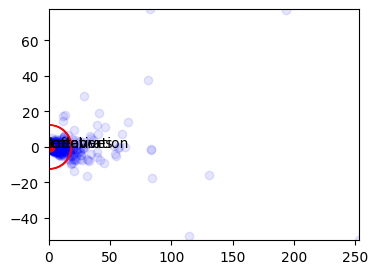

Annotating words: ['leftover', 'celebration', 'creatives']


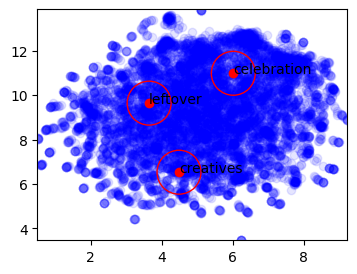

In [ ]:
for strategy in ['random', 'context', 'mean', 'subwords', 'similarity']:
    print(f"\nBuilding embedding matrix with OOV strategy: {strategy}")
    embedding_matrix = build_embedding_matrix(
        embedding_model=embedding_model,
        embedding_dimension=embedding_dimension,
        word_to_idx=word_to_idx,
        vocab_size=vocab_size,
        oov_terms=oov_terms,
        unk_token="<UNK>",
        oov_strategy=strategy,
    )

    co_occurrence_matrix = co_occurrence_count(train_df,
                                            idx_to_word,
                                            word_to_idx,
                                            window_size=4)

    rand_words = np.random.choice(list(word_to_idx.keys()), size=3, replace=False).tolist()
    run_visualization('svd',rand_words, word_to_idx, co_occurrence_matrix)
    run_visualization('umap',rand_words, word_to_idx, co_occurrence_matrix)

## Task 4

In [ ]:
batch_size = 16
hidden_dim = 128

def text_to_indices(text, word_to_idx, unk_token="<UNK>"):
    """Convert text to a list of indices based on the word_to_idx mapping."""
    return [word_to_idx.get(t, word_to_idx[unk_token]) for t in text.split()]

### Tweet Dataset

In [ ]:
class TweetDataset(Dataset):
    def __init__(self, df, word_to_idx, unk_token="<UNK>"):
        self.sequences = [text_to_indices(t, word_to_idx, unk_token) for t in df['tweet'].values]
        self.labels = df['label'].values.astype(int)

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]

# Collate function for padding
def collate_fn(batch):
    sequences, labels = zip(*batch)
    lengths = torch.tensor([len(seq) for seq in sequences])
    padded_seqs = rnn_utils.pad_sequence([torch.tensor(seq) for seq in sequences],
                                         batch_first=True, padding_value=word_to_idx["<PAD>"])
    labels = torch.tensor(labels)
    return padded_seqs, labels, lengths


train_loader = DataLoader(TweetDataset(train_df, word_to_idx), batch_size=batch_size,
                          shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(TweetDataset(val_df, word_to_idx), batch_size=batch_size,
                        shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(TweetDataset(test_df, word_to_idx), batch_size=batch_size,
                        shuffle=False, collate_fn=collate_fn)

### Bidirectional LSTM model

In [ ]:
class BiLSTMClassifier(nn.Module):
    def __init__(self, embedding_matrix, hidden_dim=128, num_classes=4, num_layers=1, dropout=0.3):
        super().__init__()
        vocab_size, embedding_dim = embedding_matrix.shape
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=False, padding_idx=word_to_idx["<PAD>"])
        self.bilstm = nn.LSTM(input_size=embedding_dim,
                              hidden_size=hidden_dim,
                              num_layers=num_layers,
                              bidirectional=True,
                              batch_first=True,
                              dropout=dropout if num_layers>1 else 0)
        self.fc = nn.Linear(hidden_dim*2, num_classes)

    def forward(self, x, lengths=None):
        embedded = self.embedding(x)
        if lengths is not None:
            packed = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(),
                                                      batch_first=True,
                                                      enforce_sorted=False)
            packed_out, (h_n, c_n) = self.bilstm(packed)
        else:
            # without lengths use full sequences
            out, (h_n, c_n) = self.bilstm(embedded)

        # hidden state concatenation
        h_forward = h_n[-2,:,:]
        h_backward = h_n[-1,:,:]
        h = torch.cat((h_forward, h_backward), dim=1)
        out = self.fc(h)
        return out

In [ ]:
baseline_model = BiLSTMClassifier(embedding_matrix=embedding_matrix, hidden_dim=hidden_dim, num_classes=4, num_layers=1, dropout=0.3)

In [ ]:
# max_string_length = train_df_stats['string_length'].max()
max_string_length = 230
print(f"Lunghezza massima del tweet in caratteri: {max_string_length}")

summary(baseline_model, input_size=(16, max_string_length), dtypes=[torch.long])

Lunghezza massima del tweet in caratteri: 230


Layer (type:depth-idx)                   Output Shape              Param #
BiLSTMClassifier                         [16, 4]                   --
├─Embedding: 1-1                         [16, 230, 50]             378,750
├─LSTM: 1-2                              [16, 230, 256]            184,320
├─Linear: 1-3                            [16, 4]                   1,028
Total params: 564,098
Trainable params: 564,098
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 684.37
Input size (MB): 0.03
Forward/backward pass size (MB): 9.01
Params size (MB): 2.26
Estimated Total Size (MB): 11.30

### Bidirectional GRU model

In [ ]:
class BiGRUClassifier(nn.Module):
    def __init__(self, embedding_matrix, hidden_dim=128, num_classes=4, num_layers=1, dropout=0.3):
        super().__init__()
        vocab_size, embedding_dim = embedding_matrix.shape

        self.embedding = nn.Embedding.from_pretrained(
            embedding_matrix,
            freeze=False,
            padding_idx=word_to_idx["<PAD>"]
        )

        self.bigru = nn.GRU(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            bidirectional=True,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )

        self.fc = nn.Linear(hidden_dim * 2, num_classes)

    def forward(self, x, lengths=None):
        embedded = self.embedding(x)

        if lengths is not None:
            packed = nn.utils.rnn.pack_padded_sequence(
                embedded,
                lengths.cpu(),
                batch_first=True,
                enforce_sorted=False
            )
            packed_out, h_n = self.bigru(packed)
        else:
            out, h_n = self.bigru(embedded)

        # h_n shape: (num_layers * num_directions, batch, hidden_dim)
        h_forward = h_n[-2, :, :]
        h_backward = h_n[-1, :, :]

        h = torch.cat((h_forward, h_backward), dim=1)

        return self.fc(h)

In [ ]:
baseline_bigru_model = BiGRUClassifier(embedding_matrix=embedding_matrix, hidden_dim=hidden_dim, num_classes=4, num_layers=1, dropout=0.3)

In [ ]:
# max_string_length = train_df_stats['string_length'].max()
max_string_length = 230
print(f"Lunghezza massima del tweet in caratteri: {max_string_length}")

summary(baseline_bigru_model, input_size=(16, max_string_length), dtypes=[torch.long])

Lunghezza massima del tweet in caratteri: 230


Layer (type:depth-idx)                   Output Shape              Param #
BiGRUClassifier                          [16, 4]                   --
├─Embedding: 1-1                         [16, 230, 50]             378,750
├─GRU: 1-2                               [16, 230, 256]            138,240
├─Linear: 1-3                            [16, 4]                   1,028
Total params: 518,018
Trainable params: 518,018
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 514.80
Input size (MB): 0.03
Forward/backward pass size (MB): 9.01
Params size (MB): 2.07
Estimated Total Size (MB): 11.11

### Bidirectional LSTM model with Attention

In [ ]:
class Attention(nn.Module):
    """
    Simple additive attention:
        score = vᵀ tanh(W*h_t)
    """
    def __init__(self, hidden_dim):
        super().__init__()
        self.W = nn.Linear(hidden_dim * 2, hidden_dim)
        self.v = nn.Linear(hidden_dim, 1, bias=False)

    def forward(self, lstm_out, mask=None):
        # lstm_out: (batch, seq, hidden*2)
        scores = self.v(torch.tanh(self.W(lstm_out)))  # (batch, seq, 1)
        scores = scores.squeeze(-1)  # (batch, seq)

        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)

        attn_weights = F.softmax(scores, dim=1)  # (batch, seq)
        attn_weights = attn_weights.unsqueeze(1)  # (batch, 1, seq)

        context = torch.bmm(attn_weights, lstm_out)  # (batch, 1, hidden*2)
        context = context.squeeze(1)  # (batch, hidden*2)

        return context


class BiLSTMAClassifier(nn.Module):
    def __init__(self, embedding_matrix, hidden_dim=128, num_classes=4, num_layers=1, dropout=0.3):
        super().__init__()
        vocab_size, embedding_dim = embedding_matrix.shape
        self.embedding = nn.Embedding.from_pretrained(
            embedding_matrix,
            freeze=False,
            padding_idx=word_to_idx["<PAD>"]
        )

        self.bilstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            bidirectional=True,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )

        self.attention = Attention(hidden_dim)
        self.fc = nn.Linear(hidden_dim * 2, num_classes)

    def forward(self, x, lengths=None):
        embedded = self.embedding(x)  # (batch, seq, emb)

        if lengths is not None:
            packed = nn.utils.rnn.pack_padded_sequence(
                embedded, lengths.cpu(), batch_first=True, enforce_sorted=False
            )
            packed_out, _ = self.bilstm(packed)
            lstm_out, _ = nn.utils.rnn.pad_packed_sequence(
                packed_out, batch_first=True
            )
            # mask: 1 = valid token
            max_len = x.size(1)
            mask = (torch.arange(max_len).to(x.device)[None, :] < lengths[:, None]).long()
        else:
            lstm_out, _ = self.bilstm(embedded)
            mask = None

        # Apply attention over all time steps
        context = self.attention(lstm_out, mask)  # (batch, hidden*2)

        logits = self.fc(context)
        return logits

In [ ]:
baseline_bilstma_model = BiLSTMAClassifier(embedding_matrix=embedding_matrix, hidden_dim=hidden_dim, num_classes=4, num_layers=1, dropout=0.3)

In [ ]:
# max_string_length = train_df_stats['string_length'].max()
max_string_length = 230
print(f"Lunghezza massima del tweet in caratteri: {max_string_length}")

summary(baseline_bilstma_model, input_size=(16, max_string_length), dtypes=[torch.long])

Lunghezza massima del tweet in caratteri: 230


Layer (type:depth-idx)                   Output Shape              Param #
BiLSTMAClassifier                        [16, 4]                   --
├─Embedding: 1-1                         [16, 230, 50]             378,750
├─LSTM: 1-2                              [16, 230, 256]            184,320
├─Attention: 1-3                         [16, 256]                 --
│    └─Linear: 2-1                       [16, 230, 128]            32,896
│    └─Linear: 2-2                       [16, 230, 1]              128
├─Linear: 1-4                            [16, 4]                   1,028
Total params: 597,122
Trainable params: 597,122
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 684.90
Input size (MB): 0.03
Forward/backward pass size (MB): 12.81
Params size (MB): 2.39
Estimated Total Size (MB): 15.22

## Task 5

Device Definition

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


#### Training functions

In [ ]:
def train_epoch(model, loader, optimizer, criterion, device):
    """
    Train the model for one epoch.

    Parameters:
      - model: the neural network model
      - loader: DataLoader for training data
      - optimizer: optimizer for updating model parameters
      - criterion: loss function
      - device: CPU or GPU
    Returns:
      - average loss and accuracy for the epoch
    """
    model.train()
    total_loss = 0.0
    all_preds, all_labels = [], []

    for batch in loader:
        inputs, labels, lengths = batch
        inputs = inputs.to(device)
        labels = labels.to(device)
        lengths = lengths.to(device)

        optimizer.zero_grad()
        outputs = model(inputs, lengths)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * inputs.size(0)
        preds = outputs.argmax(dim=1).detach().cpu().numpy()
        all_preds.append(preds)
        all_labels.append(labels.detach().cpu().numpy())

    all_preds = np.concatenate(all_preds) if all_preds else np.array([])
    all_labels = np.concatenate(all_labels) if all_labels else np.array([])

    acc = accuracy_score(all_labels, all_preds) if len(all_labels) else 0.0

    avg_loss = total_loss / len(loader.dataset)
    return avg_loss, acc

def eval_epoch(model, loader, criterion, device):
    """
    Evaluate the model for one epoch.
    Parameters:
      - model: the neural network model
      - loader: DataLoader for validation/data
      - criterion: loss function
      - device: CPU or GPU
    Returns:
      - average loss, accuracy, precision, recall, and F1-score for the epoch
    """
    model.eval()
    total_loss = 0.0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in loader:
            inputs, labels, lengths = batch
            inputs = inputs.to(device)
            labels = labels.to(device)
            lengths = lengths.to(device)

            outputs = model(inputs, lengths)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * inputs.size(0)

            preds = outputs.argmax(dim=1).cpu().numpy()
            all_preds.append(preds)
            all_labels.append(labels.cpu().numpy())

    all_preds = np.concatenate(all_preds) if all_preds else np.array([])
    all_labels = np.concatenate(all_labels) if all_labels else np.array([])

    acc = accuracy_score(all_labels, all_preds) if len(all_labels) else 0.0
    prec = precision_score(all_labels, all_preds, average='macro', zero_division=np.nan) if len(all_labels) else 0.0
    rec = recall_score(all_labels, all_preds, average='macro') if len(all_labels) else 0.0
    f1 = f1_score(all_labels, all_preds, average='macro') if len(all_labels) else 0.0

    avg_loss = total_loss / len(loader.dataset)
    return avg_loss, acc, prec, rec, f1

def train_loop(model, num_epochs, train_loader, val_loader, optimizer, criterion, device, verbose=True):
    """
    Perform the model training.
    Parameters:
      - model: the neural network model
      - num_epochs: number of training epochs
      - train_loader: DataLoader for training data
      - val_loader: DataLoader for validation data
      - optimizer: optimizer for updating model parameters
      - criterion: loss function
      - device: CPU or GPU
      - verbose: whether to print progress
    Returns:
      - history: dictionary containing training and validation metrics per epoch
    """
    best_val_acc = 0.0
    best_state = None
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': [],
        'val_prec': [],
        'val_rec': [],
        'val_f1': [],
    }

    for epoch in range(1, num_epochs + 1):
        train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, device)
        val_loss, val_acc, val_prec, val_rec, val_f1 = eval_epoch(model, val_loader, criterion, device)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['val_prec'].append(val_prec)
        history['val_rec'].append(val_rec)
        history['val_f1'].append(val_f1)

        if verbose:
            print(f"Epoch {epoch}/{num_epochs} — train loss: {train_loss:.4f} — val loss: {val_loss:.4f}, val acc: {val_acc:.4f}, val prec: {val_prec:.4f}, val rec: {val_rec:.4f}, val f1: {val_f1:.4f}")

    return history

#### Evaluation function

In [ ]:
def eval_model(model, loader, device, return_ys=False):
    """
    Evaluate the model.
    Parameters:
      - model: the neural network model
      - loader: DataLoader for evaluation data
      - device: CPU or GPU
      - return_ys: whether to return labels and predictions
    Returns:
      - accuracy, precision, recall, and F1-score
    """
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in loader:
            inputs, labels, lengths = batch
            inputs = inputs.to(device)
            labels = labels.to(device)
            lengths = lengths.to(device)

            outputs = model(inputs, lengths)
            preds = outputs.argmax(dim=1).cpu().numpy()
            all_preds.append(preds)
            all_labels.append(labels.cpu().numpy())

    all_preds = np.concatenate(all_preds) if all_preds else np.array([])
    all_labels = np.concatenate(all_labels) if all_labels else np.array([])

    acc = accuracy_score(all_labels, all_preds) if len(all_labels) else 0.0
    prec = precision_score(all_labels, all_preds, average='macro', zero_division=np.nan) if len(all_labels) else 0.0
    rec = recall_score(all_labels, all_preds, average='macro') if len(all_labels) else 0.0
    f1 = f1_score(all_labels, all_preds, average='macro') if len(all_labels) else 0.0

    if return_ys:
        return acc, prec, rec, f1, (all_labels, all_preds)
    else:
        return acc, prec, rec, f1


### BiLSTM model

#### Compare RNN layers impact

In [ ]:
seed = np.random.randint(0, 1000, size=1)[0]
fix_seed(seed)

In [ ]:
# Hyperparameters definition
num_epochs = 10
lr = 1e-4

##### Baseline: One Layer BiLSTM Model

In [ ]:
# Model BASELINE definition
model = BiLSTMClassifier(embedding_matrix, hidden_dim=hidden_dim, num_layers=1)
model.to(device)

BiLSTMClassifier(
  (embedding): Embedding(9459, 50, padding_idx=0)
  (bilstm): LSTM(50, 128, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=256, out_features=4, bias=True)
)

In [ ]:
# Loss and Optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

Single layer training: 
Accuracy: 0.7000, Precision: 0.4366, Recall: 0.3024, F1: 0.2974


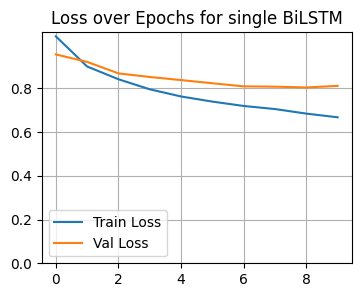

In [ ]:
# Train and Evaluation
model_history = train_loop(model, num_epochs, train_loader, val_loader, optimizer, criterion, device, verbose=False)
report = eval_model(model, val_loader, device)

print("Single layer training: ")
print("Accuracy: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1: {:.4f}".format(report[0], report[1], report[2], report[3]))
plt.figure(figsize=(4,3))
plt.plot(model_history['train_loss'], label='Train Loss')
plt.plot(model_history['val_loss'], label='Val Loss')
plt.yticks(np.arange(0, 1, 0.2))
plt.title('Loss over Epochs for single BiLSTM')
plt.grid()
plt.legend()
plt.show()

##### Stacked: two Layers BiLSTM model

In [ ]:
# Model STACKED definition
bi_stacked_model = BiLSTMClassifier(embedding_matrix, hidden_dim=hidden_dim, num_layers=2)
bi_stacked_model.to(device)

BiLSTMClassifier(
  (embedding): Embedding(9459, 50, padding_idx=0)
  (bilstm): LSTM(50, 128, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (fc): Linear(in_features=256, out_features=4, bias=True)
)

In [ ]:
# Optimizer
optimizer = optim.Adam(bi_stacked_model.parameters(), lr=lr)

Bi stacked training: 
Accuracy: 0.7200, Precision: 0.5148, Recall: 0.3535, F1: 0.3577


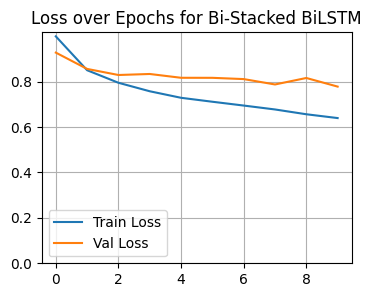

In [ ]:
# Train and Evaluation
bi_stacked_model_history = train_loop(bi_stacked_model, num_epochs, train_loader, val_loader, optimizer, criterion, device, verbose=False)
report = eval_model(bi_stacked_model, val_loader, device)

print("Bi stacked training: ")
print("Accuracy: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1: {:.4f}".format(report[0], report[1], report[2], report[3]))
plt.figure(figsize=(4,3))
plt.plot(bi_stacked_model_history['train_loss'], label='Train Loss')
plt.plot(bi_stacked_model_history['val_loss'], label='Val Loss')
plt.yticks(np.arange(0, 1, 0.2))
plt.title('Loss over Epochs for Bi-Stacked BiLSTM')
plt.grid()
plt.legend()
plt.show()

##### Stacked: three Layer BiLSTM model

In [ ]:
tri_stacked_model = BiLSTMClassifier(embedding_matrix, hidden_dim=hidden_dim, num_layers=3)
tri_stacked_model.to(device)

BiLSTMClassifier(
  (embedding): Embedding(9459, 50, padding_idx=0)
  (bilstm): LSTM(50, 128, num_layers=3, batch_first=True, dropout=0.3, bidirectional=True)
  (fc): Linear(in_features=256, out_features=4, bias=True)
)

In [ ]:
optimizer = optim.Adam(tri_stacked_model.parameters(), lr=lr)

Tri stacked training: 
Accuracy: 0.7200, Precision: 0.5235, Recall: 0.3904, F1: 0.3881


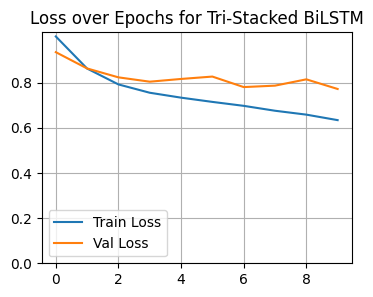

In [ ]:
tri_stacked_model_history = train_loop(tri_stacked_model, num_epochs, train_loader, val_loader, optimizer, criterion, device, verbose=False)
report = eval_model(tri_stacked_model, val_loader, device)

print("Tri stacked training: ")
print("Accuracy: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1: {:.4f}".format(report[0], report[1], report[2], report[3]))
plt.figure(figsize=(4,3))
plt.plot(tri_stacked_model_history['train_loss'], label='Train Loss')
plt.plot(tri_stacked_model_history['val_loss'], label='Val Loss')
plt.yticks(np.arange(0, 1, 0.2))
plt.title('Loss over Epochs for Tri-Stacked BiLSTM')
plt.grid()
plt.legend()
plt.show()

#### Training and Evaluation over many seeds

In [ ]:
best_model = None
best_history = None
criterion = nn.CrossEntropyLoss()
training_report = {'baseline': [], 'stacked': []}
best_f1 = 0

for seed in seeds:  # try 3 different random seeds
    print(f"\nRandom seed: {seed}")
    fix_seed(seed)
    baseline_model = BiLSTMClassifier(embedding_matrix, hidden_dim=hidden_dim, num_layers=1)
    baseline_model.to(device)
    optimizer = optim.Adam(baseline_model.parameters(), lr=lr)
    baseline_model_history = train_loop(baseline_model, num_epochs, train_loader, val_loader, optimizer, criterion, device, verbose=False)
    training_report['baseline'].append(eval_model(baseline_model, test_loader, device))
    print("Baseline training: ")
    print("Accuracy: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1: {:.4f}".format(training_report['baseline'][-1][0], training_report['baseline'][-1][1], training_report['baseline'][-1][2], training_report['baseline'][-1][3]))
    if baseline_model_history['val_f1'][-1] > best_f1:
        best_f1 = baseline_model_history['val_f1'][-1]
        best_model = copy.deepcopy(baseline_model)
        best_history = baseline_model_history

    stacked_model = BiLSTMClassifier(embedding_matrix, hidden_dim=hidden_dim, num_layers=2)
    stacked_model.to(device)
    optimizer = optim.Adam(stacked_model.parameters(), lr=lr)
    stacked_model_history = train_loop(stacked_model, num_epochs, train_loader, val_loader, optimizer, criterion, device, verbose=False)
    training_report['stacked'].append(eval_model(stacked_model, val_loader, device))
    print("Stacked training: ")
    print("Accuracy: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1: {:.4f}".format(training_report['stacked'][-1][0], training_report['stacked'][-1][1], training_report['stacked'][-1][2], training_report['stacked'][-1][3]))
    if stacked_model_history['val_f1'][-1] > best_f1:
        best_f1 = stacked_model_history['val_f1'][-1]
        best_model = copy.deepcopy(stacked_model)
        best_history = stacked_model_history

    # print("========================================")


Random seed: 616
Baseline training: 
Accuracy: 0.6107, Precision: 0.4209, Recall: 0.4257, F1: 0.4213
Stacked training: 
Accuracy: 0.6667, Precision: 0.4031, Recall: 0.4024, F1: 0.4024

Random seed: 464
Baseline training: 
Accuracy: 0.6071, Precision: 0.3339, Recall: 0.3612, F1: 0.3455
Stacked training: 
Accuracy: 0.6400, Precision: 0.3473, Recall: 0.3688, F1: 0.3564

Random seed: 500
Baseline training: 
Accuracy: 0.6321, Precision: 0.4011, Recall: 0.4157, F1: 0.4023
Stacked training: 
Accuracy: 0.6800, Precision: 0.3447, Recall: 0.3477, F1: 0.3447
Best f1 score:  0.41278617818902175


In [ ]:
for idx, metric in enumerate(['Accuracy', 'Precision', 'Recall', 'F1']):
    baseline_scores = [run[idx] for run in training_report['baseline']]
    stacked_scores = [run[idx] for run in training_report['stacked']]
    print(f"{metric} - Baseline: Mean = {np.mean(baseline_scores):.4f}, Std Dev = {np.std(baseline_scores):.4f} | Stacked: Mean = {np.mean(stacked_scores):.4f}, Std Dev = {np.std(stacked_scores):.4f}")

Accuracy - Baseline: Mean = 0.6167, Std Dev = 0.0110 | Stacked: Mean = 0.6622, Std Dev = 0.0166
Precision - Baseline: Mean = 0.3853, Std Dev = 0.0372 | Stacked: Mean = 0.3650, Std Dev = 0.0269
Recall - Baseline: Mean = 0.4009, Std Dev = 0.0283 | Stacked: Mean = 0.3730, Std Dev = 0.0225
F1 - Baseline: Mean = 0.3897, Std Dev = 0.0322 | Stacked: Mean = 0.3678, Std Dev = 0.0249


#### Visualizations for the best model

##### Evaluation metrics

Precision, Recall, F1 over the epochs

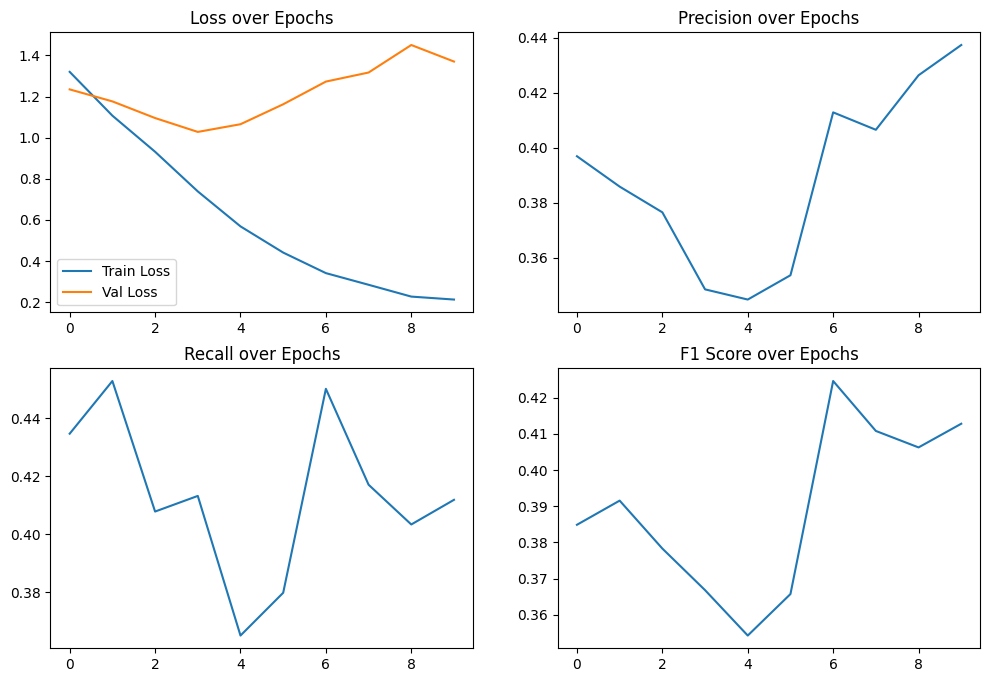

In [ ]:
plt.figure(figsize=(12,8))
plt.subplot(2, 2, 1)
plt.plot(best_history['train_loss'], label='Train Loss')
plt.plot(best_history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(best_history['val_prec'], label='Val Precision')
plt.title('Precision over Epochs')

plt.subplot(2, 2, 3)
plt.plot(best_history['val_rec'], label='Val Recall')
plt.title('Recall over Epochs')

plt.subplot(2, 2, 4)
plt.plot(best_history['val_f1'], label='Val F1')
plt.title('F1 Score over Epochs')

plt.show()

Confusion matrix

In [ ]:
best_acc, best_prec, best_rec, best_f1, (all_labels, all_preds) = \
    eval_model(best_model, test_loader, device, return_ys=True)

c:\Users\matti\anaconda3\envs\ai\Lib\site-packages\torch\nn\modules\rnn.py:1136: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\cudnn\RNN.cpp:1481.)
  result = _VF.lstm(


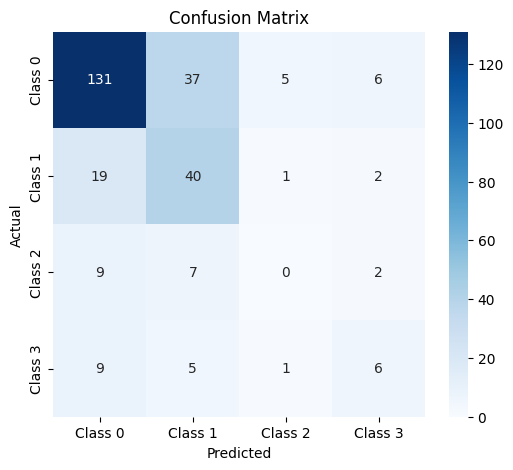

In [ ]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3'],
            yticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

Precision-Recall curve

c:\Users\matti\anaconda3\envs\ai\Lib\site-packages\torch\nn\modules\rnn.py:1136: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\cudnn\RNN.cpp:1481.)
  result = _VF.lstm(
c:\Users\matti\anaconda3\envs\ai\Lib\site-packages\torch\nn\modules\rnn.py:1136: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\cudnn\RNN.cpp:1481.)
  result = _VF.lstm(


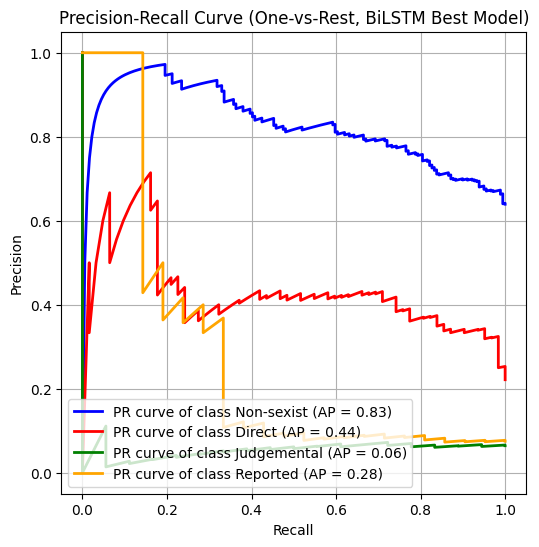

In [ ]:
from itertools import cycle

# Get predictions and probabilities for the test set
best_acc, best_prec, best_rec, best_f1, (all_labels, all_preds) = eval_model(best_model, test_loader, device, return_ys=True)

# Get logits for each class
all_probs = []
best_model.eval()
with torch.no_grad():
    for batch in test_loader:
        inputs, labels, lengths = batch
        inputs = inputs.to(device)
        lengths = lengths.to(device)
        logits = best_model(inputs, lengths)
        probs = torch.softmax(logits, dim=1).cpu().numpy()
        all_probs.append(probs)
all_probs = np.concatenate(all_probs, axis=0)

# Plot Precision-Recall curve for each class
plt.figure(figsize=(6,6))
colors = cycle(['blue', 'red', 'green', 'orange'])
class_labels = ['Non-sexist', 'Direct', 'Judgemental', 'Reported']

for i, color in zip(range(4), colors):
    binary_labels = (all_labels == i)
    precision, recall, _ = precision_recall_curve(binary_labels, all_probs[:, i])
    ap = average_precision_score(binary_labels, all_probs[:, i])
    plt.plot(recall, precision, color=color, lw=2,
             label=f'PR curve of class {class_labels[i]} (AP = {ap:.2f})')

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (One-vs-Rest, BiLSTM Best Model)")
plt.legend(loc="lower left")
plt.grid(True)
plt.show()

ROC curve

c:\Users\matti\anaconda3\envs\ai\Lib\site-packages\torch\nn\modules\rnn.py:1136: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\cudnn\RNN.cpp:1481.)
  result = _VF.lstm(


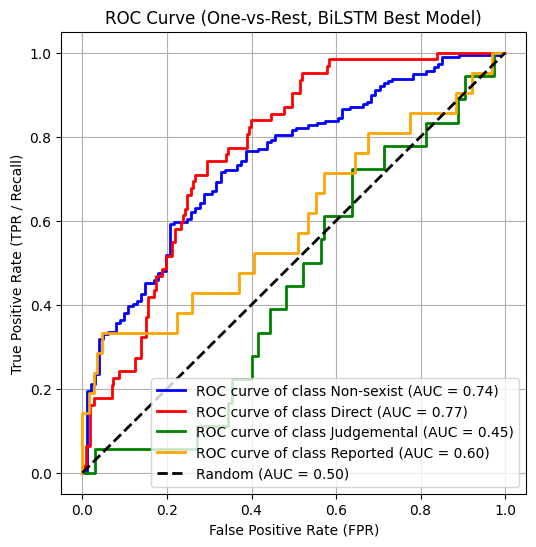

In [ ]:
from itertools import cycle

# Get predictions and probabilities for the test set
best_model.eval()
all_probs = []
all_labels = []
with torch.no_grad():
    for batch in test_loader:
        inputs, labels, lengths = batch
        inputs = inputs.to(device)
        lengths = lengths.to(device)
        logits = best_model(inputs, lengths)
        probs = torch.softmax(logits, dim=1).cpu().numpy()
        all_probs.append(probs)
        all_labels.append(labels.cpu().numpy())
all_probs = np.concatenate(all_probs, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

plt.figure(figsize=(6,6))
colors = cycle(['blue', 'red', 'green', 'orange'])
class_labels = ['Non-sexist', 'Direct', 'Judgemental', 'Reported']

for i, color in zip(range(4), colors):
    binary_labels = (all_labels == i)
    fpr, tpr, _ = roc_curve(binary_labels, all_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=color, lw=2,
             label=f'ROC curve of class {class_labels[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random (AUC = 0.50)')
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR / Recall)")
plt.title("ROC Curve (One-vs-Rest, BiLSTM Best Model)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

##### Results on the actual data

In [ ]:
# Print some predictions with the best model
best_model.eval()
with torch.no_grad():
    for batch in val_loader:
        inputs, labels, lengths = batch
        inputs = inputs.to(device)
        labels = labels.to(device)
        lengths = lengths.to(device)
        outputs = best_model(inputs, lengths)
        preds = outputs.argmax(dim=1).cpu().numpy()

        for i in range(inputs.size(0)):
            if labels[i].item() != 0:  # print only non-neutral tweets
                input_indices = inputs[i][:lengths[i]].cpu().numpy()
                input_words = [idx_to_word[idx] for idx in input_indices]
                print("Tweet:", " ".join(input_words))
                print("True label:", labels[i].item())
                print("Predicted label:", preds[i])
                print("")

Tweet: right push opposite direction convert female space <UNK> sex deny woman girl privacy safety male free area male behaviour problem female behaviour change must preserve boundary
True label: 3
Predicted label: 0

Tweet: man move <UNK> <UNK> <UNK> <UNK> train think good position completely reach rush train couple stop woman cant <UNK> <UNK> apparently
True label: 3
Predicted label: 0

Tweet: every second american sexually <UNK> read decide care survey find woman experience street harassment among woman sexually touch
True label: 3
Predicted label: 3

Tweet: sincerely wish u progressive womens right
True label: 2
Predicted label: 0

Tweet: need call day without woman woman amp ally usa <UNK> <UNK> <UNK>
True label: 1
Predicted label: 1

Tweet: day without woman would really economy
True label: 1
Predicted label: 0

Tweet: nearly student encounter sexual misconduct school
True label: 3
Predicted label: 0

Tweet: first scar stalking find <UNK> side realize sweet salty like good treat 

c:\Users\matti\anaconda3\envs\ai\Lib\site-packages\torch\nn\modules\rnn.py:1136: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\cudnn\RNN.cpp:1481.)
  result = _VF.lstm(


#### Training for different oov strategies

In [ ]:
for strategy in ['random', 'context', 'mean', 'subwords', 'similarity']:
    print(f"\nOOV strategy: {strategy}")
    embedding_matrix = build_embedding_matrix(
        embedding_model=embedding_model,
        embedding_dimension=embedding_dimension,
        word_to_idx=word_to_idx,
        vocab_size=vocab_size,
        oov_terms=oov_terms,
        unk_token="<UNK>",
        oov_strategy=strategy,
    )

    best_model = None
    best_history = None
    criterion = nn.CrossEntropyLoss()
    training_report = {'stacked': []}
    seeds = np.random.randint(0, 1000, size=3)
    best_f1 = 0

    for seed in seeds:
        stacked_model = BiLSTMClassifier(embedding_matrix, hidden_dim=hidden_dim, num_layers=2)
        stacked_model.to(device)
        optimizer = optim.Adam(stacked_model.parameters(), lr=lr)
        stacked_model_history = train_loop(stacked_model, num_epochs, train_loader, val_loader, optimizer, criterion, device, verbose=False)
        training_report['stacked'].append(eval_model(stacked_model, val_loader, device))
        if stacked_model_history['val_f1'][-1] > best_f1:
            best_f1 = stacked_model_history['val_f1'][-1]
            best_model = copy.deepcopy(stacked_model)
            best_history = stacked_model_history

    print("Best f1 score: ", best_f1)
    for idx, metric in enumerate(['Accuracy', 'Precision', 'Recall', 'F1']):
        stacked_scores = [run[idx] for run in training_report['stacked']]
        print(f"{metric} - Stacked: Mean = {np.mean(stacked_scores):.4f}, Std Dev = {np.std(stacked_scores):.4f}")


OOV strategy: random


Building embedding matrix: 100%|██████████| 9459/9459 [00:00<00:00, 116377.55it/s]


### BiGRU model

#### Baseline: one Layer BiGRU model

In [ ]:
lr = 1e-4

In [ ]:
model = BiGRUClassifier(embedding_matrix, hidden_dim=hidden_dim, num_layers=1)
model.to(device)

BiGRUClassifier(
  (embedding): Embedding(7575, 50, padding_idx=0)
  (bigru): GRU(50, 128, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=256, out_features=4, bias=True)
)

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=lr)

Single layer training: 
Accuracy: 0.6733, Precision: 0.3872, Recall: 0.3807, F1: 0.3835


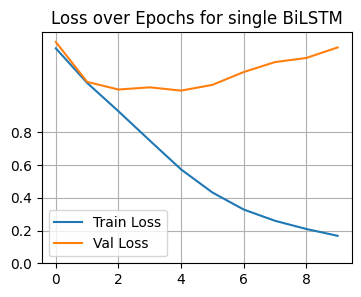

In [ ]:
model_history = train_loop(model, num_epochs, train_loader, val_loader, optimizer, criterion, device, verbose=False)
report = eval_model(model, val_loader, device)

print("Single layer training: ")
print("Accuracy: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1: {:.4f}".format(report[0], report[1], report[2], report[3]))
plt.figure(figsize=(4,3))
plt.plot(model_history['train_loss'], label='Train Loss')
plt.plot(model_history['val_loss'], label='Val Loss')
plt.yticks(np.arange(0, 1, 0.2))
plt.title('Loss over Epochs for single BiLSTM')
plt.grid()
plt.legend()
plt.show()

#### Stacked: two Layers BiGRU model

In [ ]:
bi_stacked_model = BiGRUClassifier(embedding_matrix, hidden_dim=hidden_dim, num_layers=2)
bi_stacked_model.to(device)

BiGRUClassifier(
  (embedding): Embedding(7575, 50, padding_idx=0)
  (bigru): GRU(50, 128, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (fc): Linear(in_features=256, out_features=4, bias=True)
)

In [ ]:
optimizer = optim.Adam(bi_stacked_model.parameters(), lr=lr)

Bi stacked training: 
Accuracy: 0.7000, Precision: 0.4657, Recall: 0.4298, F1: 0.4353


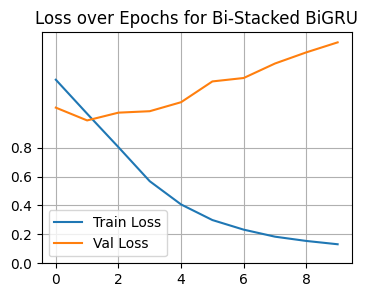

In [ ]:
bi_stacked_model_history = train_loop(bi_stacked_model, num_epochs, train_loader, val_loader, optimizer, criterion, device, verbose=False)
report = eval_model(bi_stacked_model, val_loader, device)

print("Bi stacked training: ")
print("Accuracy: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1: {:.4f}".format(report[0], report[1], report[2], report[3]))
plt.figure(figsize=(4,3))
plt.plot(bi_stacked_model_history['train_loss'], label='Train Loss')
plt.plot(bi_stacked_model_history['val_loss'], label='Val Loss')
plt.yticks(np.arange(0, 1, 0.2))
plt.title('Loss over Epochs for Bi-Stacked BiGRU')
plt.grid()
plt.legend()
plt.show()

#### Stacked: three Layers BiGRU model

In [ ]:
tri_stacked_model = BiGRUClassifier(embedding_matrix, hidden_dim=hidden_dim, num_layers=3)
tri_stacked_model.to(device)

BiGRUClassifier(
  (embedding): Embedding(7575, 50, padding_idx=0)
  (bigru): GRU(50, 128, num_layers=3, batch_first=True, dropout=0.3, bidirectional=True)
  (fc): Linear(in_features=256, out_features=4, bias=True)
)

In [ ]:
optimizer = optim.Adam(tri_stacked_model.parameters(), lr=lr)

Tri stacked training: 
Accuracy: 0.6467, Precision: 0.3859, Recall: 0.3981, F1: 0.3874


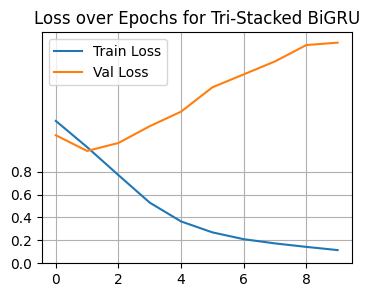

In [ ]:
tri_stacked_model_history = train_loop(tri_stacked_model, num_epochs, train_loader, val_loader, optimizer, criterion, device, verbose=False)
report = eval_model(tri_stacked_model, val_loader, device)

print("Tri stacked training: ")
print("Accuracy: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1: {:.4f}".format(report[0], report[1], report[2], report[3]))
plt.figure(figsize=(4,3))
plt.plot(tri_stacked_model_history['train_loss'], label='Train Loss')
plt.plot(tri_stacked_model_history['val_loss'], label='Val Loss')
plt.yticks(np.arange(0, 1, 0.2))
plt.title('Loss over Epochs for Tri-Stacked BiGRU')
plt.grid()
plt.legend()
plt.show()

### BiLSTM Attention model

#### Baseline: one Layer BiLSTM Attention model

In [ ]:
model = BiLSTMAClassifier(embedding_matrix, hidden_dim=hidden_dim, num_layers=1, dropout=0.3)
model.to(device)

BiLSTMAClassifier(
  (embedding): Embedding(7575, 50, padding_idx=0)
  (bilstm): LSTM(50, 128, batch_first=True, bidirectional=True)
  (attention): Attention(
    (W): Linear(in_features=256, out_features=128, bias=True)
    (v): Linear(in_features=128, out_features=1, bias=False)
  )
  (fc): Linear(in_features=256, out_features=4, bias=True)
)

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=lr)

Single layer training: 
Accuracy: 0.6267, Precision: 0.3505, Recall: 0.3471, F1: 0.3465


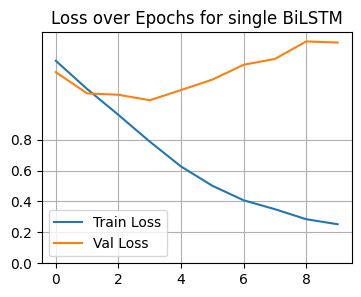

In [ ]:
model_history = train_loop(model, num_epochs, train_loader, val_loader, optimizer, criterion, device, verbose=False)
report = eval_model(model, val_loader, device)

print("Single layer training: ")
print("Accuracy: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1: {:.4f}".format(report[0], report[1], report[2], report[3]))
plt.figure(figsize=(4,3))
plt.plot(model_history['train_loss'], label='Train Loss')
plt.plot(model_history['val_loss'], label='Val Loss')
plt.yticks(np.arange(0, 1, 0.2))
plt.title('Loss over Epochs for single BiLSTM')
plt.grid()
plt.legend()
plt.show()

#### Stacked: two Layers BiLSTM Attention model

In [ ]:
bi_stacked_model = BiLSTMAClassifier(embedding_matrix, hidden_dim=hidden_dim, num_layers=2, dropout=0.3)
bi_stacked_model.to(device)

BiLSTMAClassifier(
  (embedding): Embedding(7575, 50, padding_idx=0)
  (bilstm): LSTM(50, 128, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (attention): Attention(
    (W): Linear(in_features=256, out_features=128, bias=True)
    (v): Linear(in_features=128, out_features=1, bias=False)
  )
  (fc): Linear(in_features=256, out_features=4, bias=True)
)

In [ ]:
optimizer = optim.Adam(bi_stacked_model.parameters(), lr=lr)

Bi stacked training: 
Accuracy: 0.6667, Precision: 0.3732, Recall: 0.4038, F1: 0.3822


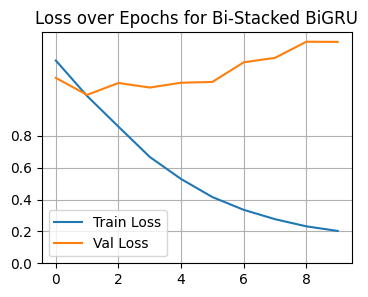

In [ ]:
bi_stacked_model_history = train_loop(bi_stacked_model, num_epochs, train_loader, val_loader, optimizer, criterion, device, verbose=False)
report = eval_model(bi_stacked_model, val_loader, device)

print("Bi stacked training: ")
print("Accuracy: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1: {:.4f}".format(report[0], report[1], report[2], report[3]))
plt.figure(figsize=(4,3))
plt.plot(bi_stacked_model_history['train_loss'], label='Train Loss')
plt.plot(bi_stacked_model_history['val_loss'], label='Val Loss')
plt.yticks(np.arange(0, 1, 0.2))
plt.title('Loss over Epochs for Bi-Stacked BiGRU')
plt.grid()
plt.legend()
plt.show()

#### Stacked: three Layers BiLSTM Attention model

In [ ]:
tri_stacked_model = BiLSTMAClassifier(embedding_matrix, hidden_dim=hidden_dim, num_layers=3, dropout=0.3)
tri_stacked_model.to(device)

BiLSTMAClassifier(
  (embedding): Embedding(7575, 50, padding_idx=0)
  (bilstm): LSTM(50, 128, num_layers=3, batch_first=True, dropout=0.3, bidirectional=True)
  (attention): Attention(
    (W): Linear(in_features=256, out_features=128, bias=True)
    (v): Linear(in_features=128, out_features=1, bias=False)
  )
  (fc): Linear(in_features=256, out_features=4, bias=True)
)

In [ ]:
optimizer = optim.Adam(tri_stacked_model.parameters(), lr=lr)

Tri stacked training: 
Accuracy: 0.6733, Precision: 0.3774, Recall: 0.3907, F1: 0.3834


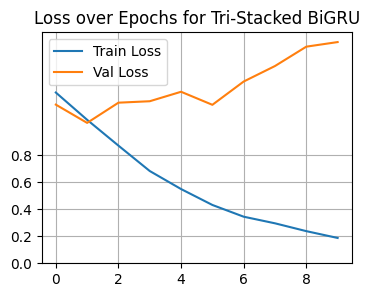

In [ ]:
tri_stacked_model_history = train_loop(tri_stacked_model, num_epochs, train_loader, val_loader, optimizer, criterion, device, verbose=False)
report = eval_model(tri_stacked_model, val_loader, device)

print("Tri stacked training: ")
print("Accuracy: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1: {:.4f}".format(report[0], report[1], report[2], report[3]))
plt.figure(figsize=(4,3))
plt.plot(tri_stacked_model_history['train_loss'], label='Train Loss')
plt.plot(tri_stacked_model_history['val_loss'], label='Val Loss')
plt.yticks(np.arange(0, 1, 0.2))
plt.title('Loss over Epochs for Tri-Stacked BiGRU')
plt.grid()
plt.legend()
plt.show()

## Task 6

#### Model definition

In [20]:
# We don't have to use the already preprocessed dataframes, because RoBERTa has its own preprocessing
train_data = Dataset.from_pandas(train_df_np)
val_data = Dataset.from_pandas(val_df_np)
test_data = Dataset.from_pandas(test_df_np)

In [21]:
# visualize datasets
print(f"---- Train dataset visualization: ----\n {train_data}")
print(f"\n---- Test dataset visualization: ----\n {test_data}")


---- Train dataset visualization: ----
 Dataset({
    features: ['id_EXIST', 'lang', 'tweet', 'label', '__index_level_0__'],
    num_rows: 2873
})

---- Test dataset visualization: ----
 Dataset({
    features: ['id_EXIST', 'lang', 'tweet', 'label', '__index_level_0__'],
    num_rows: 280
})


In [22]:
# define model_card and model tokenizer
task='hate'
MODEL = f"cardiffnlp/twitter-roberta-base-{task}"
print(MODEL)

cardiffnlp/twitter-roberta-base-hate


#### Tokenizer definition

In [23]:
tokenizer = AutoTokenizer.from_pretrained(MODEL)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/700 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

In [24]:
def show_differences(old_dataset, new_dataset, num_examples=3):
  """
  Displays random examples of differences between two datasets
  (before and after preprocessing) by comparing elements at the same index.

  Args:
    old_dataset: The original dataset.
    new_dataset: The preprocessed dataset.
    num_examples: The number of random examples to display.
  """
  if len(old_dataset) != len(new_dataset):
    raise ValueError("The two datasets must have the same length")

  for _ in range(0, num_examples):
    idx = np.random.randint(0, len(old_dataset))

    print("=====================")
    print(f"Random Example (Index {idx}):\n")
    print(f"Tweet before preprocessing: {old_dataset[idx]}")
    print(f"Tweet after preprocessing: {new_dataset[idx]}")


In [25]:
# From Roberta-base-hate documentation
def preprocess_batch(batch):
    processed = []
    for text in batch["tweet"]:
        new_text = []
        for t in text.split(" "):
            t = '@user' if t.startswith('@') and len(t) > 1 else t
            t = 'http' if t.startswith('http') else t
            new_text.append(t)
        processed.append(" ".join(new_text))
    batch["tweet"] = processed
    return batch

In [26]:
old_train_tweets = train_data['tweet']
old_val_tweets = val_data['tweet']
old_test_tweets = test_data['tweet']

train_data = train_data.map(preprocess_batch, batched=True)
val_data = val_data.map(preprocess_batch, batched=True)
test_data = test_data.map(preprocess_batch, batched=True)

new_train_tweets = train_data['tweet']
new_val_tweets = val_data['tweet']
new_test_tweets = test_data['tweet']

show_differences(old_train_tweets, new_train_tweets)

Map:   0%|          | 0/2873 [00:00<?, ? examples/s]

Map:   0%|          | 0/150 [00:00<?, ? examples/s]

Map:   0%|          | 0/280 [00:00<?, ? examples/s]

Random Example (Index 2732):

Tweet before preprocessing: First woman who was awarded with Nobel Prize was Polish scientist. All the more so Polish women have to fight to be independent and equal towards men. Women are not worse humans thus they have to have a right to decide about their rights and body! #NotOneMore https://t.co/IYFlM0jzFI
Tweet after preprocessing: First woman who was awarded with Nobel Prize was Polish scientist. All the more so Polish women have to fight to be independent and equal towards men. Women are not worse humans thus they have to have a right to decide about their rights and body! #NotOneMore http
Random Example (Index 2607):

Tweet before preprocessing: Put That Woman First https://t.co/rZ6CvHDFOw via @YouTube https://t.co/vv6dWbDGzR
Tweet after preprocessing: Put That Woman First http via @user http
Random Example (Index 1653):

Tweet before preprocessing: Amazing. Great data reporting. Not-great underlying clinical practice. To say the least. https://t.c

### Dataset Inspection

In [27]:
def preprocess_text(texts):
    return tokenizer(texts['tweet'], truncation=False)

train_data = train_data.map(preprocess_text, batched=True)
test_data = test_data.map(preprocess_text, batched=True)
val_data = val_data.map(preprocess_text, batched=True)

Map:   0%|          | 0/2873 [00:00<?, ? examples/s]

Map:   0%|          | 0/280 [00:00<?, ? examples/s]

Map:   0%|          | 0/150 [00:00<?, ? examples/s]

In [28]:
print(train_data)
print(test_data)

Dataset({
    features: ['id_EXIST', 'lang', 'tweet', 'label', '__index_level_0__', 'input_ids', 'attention_mask'],
    num_rows: 2873
})
Dataset({
    features: ['id_EXIST', 'lang', 'tweet', 'label', '__index_level_0__', 'input_ids', 'attention_mask'],
    num_rows: 280
})


In [ ]:
# Show example
idx = np.random.randint(0, len(train_data))

print("Original tweet text:")
print(train_data['tweet'][idx][:200])

print("\nFirst 200 input IDs for a random example:")
print(train_data['input_ids'][idx][:200])

print("\nFirst 200 attention mask values:")
print(train_data['attention_mask'][idx][:200])


Original tweet text:
Never forget that Kobe spent an offseason begging the Lakers to trade him and they didn't. Everything with Ben Simmons is in the hands of the Sixers. The empowerment talk is nonsense #NBATwitter

First 200 input IDs for a random example:
[0, 22491, 4309, 14, 24058, 1240, 41, 7410, 22901, 5, 6772, 7, 721, 123, 8, 51, 399, 75, 4, 9567, 19, 1664, 10215, 16, 11, 5, 1420, 9, 5, 21200, 4, 20, 17843, 1067, 16, 20175, 849, 20485, 2571, 605, 7915, 2]

First 200 attention mask values:
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


#### Roberta special tokens

We have seen that 0 and 2 ids are the first and last tokens of the tweet

In [ ]:
for name, token in tokenizer.special_tokens_map.items():
    print(f"{name}: {token} -> id {tokenizer.convert_tokens_to_ids(token)}")

bos_token: <s> -> id 0
eos_token: </s> -> id 2
unk_token: <unk> -> id 3
sep_token: </s> -> id 2
pad_token: <pad> -> id 1
cls_token: <s> -> id 0
mask_token: <mask> -> id 50264


RoBERTa’s tokenizer works at the byte level and uses a special character, “Ġ”, to indicate that a token begins with a space. This is why we see tokens like “ĠGreat” or “Ġdata”: the “Ġ” simply marks that these words originally had a space before them.

In [ ]:
example_test = train_data['tweet'][idx]
encoded_example = tokenizer.encode_plus(example_test, add_special_tokens=False)
print(encoded_example.tokens())

['First', 'Ġwoman', 'Ġwho', 'Ġwas', 'Ġawarded', 'Ġwith', 'ĠNobel', 'ĠPrize', 'Ġwas', 'ĠPolish', 'Ġscientist', '.', 'ĠAll', 'Ġthe', 'Ġmore', 'Ġso', 'ĠPolish', 'Ġwomen', 'Ġhave', 'Ġto', 'Ġfight', 'Ġto', 'Ġbe', 'Ġindependent', 'Ġand', 'Ġequal', 'Ġtowards', 'Ġmen', '.', 'ĠWomen', 'Ġare', 'Ġnot', 'Ġworse', 'Ġhumans', 'Ġthus', 'Ġthey', 'Ġhave', 'Ġto', 'Ġhave', 'Ġa', 'Ġright', 'Ġto', 'Ġdecide', 'Ġabout', 'Ġtheir', 'Ġrights', 'Ġand', 'Ġbody', '!', 'Ġ#', 'Not', 'One', 'More', 'Ġhttp']


In [82]:
def show_tokenization_examples(dataset, tokenizer, text_column="tweet", n=2, max_len=200):
    """
    Display original text and tokenizer-decoded text side by side for N random examples.

    Parameters:
      - dataset: Hugging Face Dataset (already tokenized)
      - tokenizer: Hugging Face tokenizer
      - text_column: name of the column containing the original text
      - n: number of random examples to display
      - max_len: maximum number of characters to print
    """
    total = len(dataset)
    indices = random.sample(range(total), n)

    for idx in indices:
        original_text = dataset[text_column][idx]
        input_ids = dataset['input_ids'][idx]
        decoded_text = tokenizer.decode(input_ids)

        print(f"=== Example {idx} ===")
        print("Original text:")
        print(original_text[:max_len])
        print("\nDecoded text from tokenizer:")
        print(decoded_text[:max_len])
        print("-" * 50)

In [ ]:
show_tokenization_examples(
    dataset=train_data,
    tokenizer=AutoTokenizer.from_pretrained(MODEL)
)

=== Example 2039 ===
Original text:
I will never understand how niggas are worried about someone's sexual identity and lifestyle unless they are dating. But even then why are you worried about what others that you don't know personally 

Decoded text from tokenizer:
<s>I will never understand how niggas are worried about someone's sexual identity and lifestyle unless they are dating. But even then why are you worried about what others that you don't know personal
--------------------------------------------------
=== Example 201 ===
Original text:
@user @user @user He used hi influence to mentally and physically force a young woman into sleeping with him… she had to give her emotions to ease the pain …it’s still abuse and rape

Decoded text from tokenizer:
<s>@user @user @user He used hi influence to mentally and physically force a young woman into sleeping with him… she had to give her emotions to ease the pain …it’s still abuse and rape</s>
-------------------------------------------

### Model creation and training

In [53]:
# format input data to be fed as mini-batches: pad each tweet based on the longest tweet in the mini-batch
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Since RoBERTa was originally trained for 2 classes, but we want to predict 4 classes in our task, we need to set `ignore_mismatched_sizes=True` when loading the model. This way, the pre-trained weights are kept for all compatible layers, while the classification head is randomly initialized to match the new number of classes.


In [54]:
num_labels = len(np.unique(train_df_np['label']))
id2label = {
    '-': 0,
    'DIRECT': 1,
    'JUDGEMENTAL': 2,
    'REPORTED': 3
}
label2id = {v:k for k,v in id2label.items()}


In [64]:
# used only to show roberta architecture,
# but we will call this again, each time with different seed (for reproducibility)

config = AutoConfig.from_pretrained(
    MODEL,
    num_labels=4,
    id2label=id2label,
    label2id=label2id
)

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL,
    config=config,
    ignore_mismatched_sizes=True
)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-hate and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([2, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([2]) in the checkpoint and torch.Size([4]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [65]:
# as we can see, now the out_features=4 for the last layer
print(model)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

### Metric Definition
We will use the metrics provided by HF.

In [44]:
acc_metric = load('accuracy')
f1_metric = load('f1')

In [45]:
def compute_metrics_HF(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=-1)

    f1 = f1_metric.compute(predictions=predictions,
                           references=labels,
                           average="macro")

    acc = acc_metric.compute(predictions=predictions,
                             references=labels)

    return {"f1": f1["f1"], "accuracy": acc["accuracy"]}

In [63]:
# use same hyperparam as BiRNN
batch_size = 16
lr = 1e-4
num_epochs = 10

### Training Function

In [50]:
def train_evaluate_over_seeds(
    seeds,
    model_name,
    base_training_args,
    train_data,
    val_data,
    test_data,
    tokenizer,
    data_collator,
    compute_metrics,
    id2label,
    label2id,
    fix_seed_fn,
    output_dir_root,
    csv_output_name,
    model_output_name
):
    """
    Runs the training loop over multiple seeds, saves the best model state based on
    Validation F1, and returns a DataFrame with aggregated results.
    """

    val_results, test_results = [], []
    best_val_f1 = -1
    best_model_state = None
    best_seed = None

    for seed in seeds:
        print(f"\n============================")
        print(f" Running with seed: {seed}")
        print(f"============================\n")

        # Set the seed (ensure fix_seed_fn is defined or passed correctly)
        fix_seed_fn(seed)

        # Deep copy arguments to avoid modifying the original object
        run_args = copy.deepcopy(base_training_args)
        run_args.output_dir = f"{output_dir_root}/seed_{seed}"

        # Model Configuration
        config = AutoConfig.from_pretrained(
            model_name,
            num_labels=len(id2label),
            id2label=id2label,
            label2id=label2id
        )

        model = AutoModelForSequenceClassification.from_pretrained(
            model_name,
            config=config,
            ignore_mismatched_sizes=True
        )

        trainer = Trainer(
            model=model,
            args=run_args,
            train_dataset=train_data,
            eval_dataset=val_data,
            processing_class=tokenizer,
            data_collator=data_collator,
            compute_metrics=compute_metrics,
            callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
        )

        trainer.train()

        # --- Evaluate on Validation set ---
        # we evaluate "again" the val set just in order to compute also the val loss (for the final comparison)
        val_metrics = trainer.evaluate(val_data)
        val_log_entry = {
            "seed": seed,
            "val_f1": val_metrics["eval_f1"],
            "val_loss": val_metrics["eval_loss"]
        }
        val_results.append(val_log_entry)

        print(f"Validation F1 for seed {seed}: {val_log_entry['val_f1']:.4f}")

        # Model selection based on val_f1
        if val_log_entry["val_f1"] > best_val_f1:
            print(f"New Best Model found (Seed {seed}) based on Val F1")
            best_val_f1 = val_log_entry["val_f1"]
            # Move state dict to CPU to save VRAM while the loop continues
            best_model_state = {k: v.cpu() for k, v in model.state_dict().items()}
            best_seed = seed

        # --- Evaluate on Test Set ---
        test_metrics = trainer.evaluate(test_data)
        test_log_entry = {
            "seed": seed,
            "test_f1": test_metrics["eval_f1"],
            "test_loss": test_metrics["eval_loss"]
        }
        test_results.append(test_log_entry)

        print(f"Test F1 for seed {seed}: {test_log_entry['test_f1']:.4f}")

        # --- MEMORY CLEANUP ---
        del model
        del trainer
        torch.cuda.empty_cache()
        gc.collect()

    # --- FINAL RESULTS AND REPORTING ---
    df_val = pd.DataFrame(val_results)
    df_test = pd.DataFrame(test_results)

    # Merge Validation and Test results
    df = pd.merge(df_val, df_test, on="seed")

    print("\n===== Results per Seed (Val & Test) =====")
    print(df)

    mean_f1 = df["test_f1"].mean()
    std_f1 = df["test_f1"].std()

    print("\n===== Aggregated Results =====")
    print(f"Mean F1 (on Test Set): {mean_f1:.4f}")
    print(f"Std Dev F1 (on Test Set): {std_f1:.4f}")

    print("\nBest seed (selected using Validation F1):", best_seed)
    print("Best F1 Validation Score:", best_val_f1)

    # Retrieve the test score associated with the best seed
    best_seed_test_f1 = df[df['seed'] == best_seed]['test_f1'].iloc[0]
    print(f"Test F1 associated with the best seed: {best_seed_test_f1:.4f}")

    # Save results to file
    df.to_csv(csv_output_name, index=False)
    if best_model_state is not None:
        torch.save(best_model_state, model_output_name)
        print(f"Best model saved to {model_output_name}")

    return best_model_state, best_seed

### Training Model - First Attempt

In [51]:
training_args_1e4 = TrainingArguments(
    output_dir="val_dir/trainer_1",             # where to save model
    learning_rate=lr,
    per_device_train_batch_size=batch_size,     # defines distributed training
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epochs,
    weight_decay=0.01,
    eval_strategy="epoch",             # when to report evaluation metrics/losses
    save_strategy="epoch",             # when to save checkpoint
    logging_strategy="epoch",
    load_best_model_at_end=True,
    report_to='none',
    metric_for_best_model="f1",
    greater_is_better=True,
    warmup_ratio=0.1 # RoBERTa benefits from a small warmup
)

In [55]:
best_state, best_seed = train_evaluate_over_seeds(
    seeds=seeds,
    model_name=MODEL,
    base_training_args=training_args_1e4,
    train_data=train_data,
    val_data=val_data,
    test_data=test_data,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics_HF,
    id2label=id2label,
    label2id=label2id,
    fix_seed_fn=fix_seed,
    output_dir_root="./results/lr_1e4",
    csv_output_name="roberta_seed_results_lr_1e4.csv",
    model_output_name="best_roberta_model_lr_1e4.pt"
)


 Running with seed: 42



pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-hate and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([2, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([2]) in the checkpoint and torch.Size([4]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1,Accuracy
1,0.463900,1.113459,0.576885,0.793333


Validation F1 for seed 42: 0.5769
New Best Model found (Seed 42) based on Val F1
Test F1 for seed 42: 0.5287

 Running with seed: 1337



Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-hate and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([2, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([2]) in the checkpoint and torch.Size([4]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1,Accuracy
1,0.482800,1.058800,0.625384,0.800000


Validation F1 for seed 1337: 0.6254
New Best Model found (Seed 1337) based on Val F1
Test F1 for seed 1337: 0.4844

 Running with seed: 2025



Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-hate and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([2, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([2]) in the checkpoint and torch.Size([4]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1,Accuracy
1,0.463200,1.191920,0.562743,0.786667


Validation F1 for seed 2025: 0.5627
Test F1 for seed 2025: 0.5622

===== Results per Seed (Val & Test) =====
   seed    val_f1  val_loss   test_f1  test_loss
0    42  0.576885  1.113459  0.528651   1.250985
1  1337  0.625384  1.058800  0.484361   1.330373
2  2025  0.562743  1.191920  0.562167   1.272087

===== Aggregated Results =====
Mean F1 (on Test Set): 0.5251
Std Dev F1 (on Test Set): 0.0390

Best seed (selected using Validation F1): 1337
Best F1 Validation Score: 0.625384012539185
Test F1 associated with the best seed: 0.4844
Best model saved to best_roberta_model_lr_1e4.pt


In [ ]:
'''
# TO ELIMINATE
val_results, test_results = [], []
best_val_f1 = -1
best_model_state = None
best_seed = None

for seed in seeds:
    print(f"\n============================")
    print(f" Running with seed: {seed}")
    print(f"============================\n")

    fix_seed(seed)

    run_args = copy.deepcopy(training_args)
    run_args.output_dir = f"./results/lr_1e4/seed_{seed}"

    config = AutoConfig.from_pretrained(
        MODEL, num_labels=4, id2label=id2label, label2id=label2id
    )

    model = AutoModelForSequenceClassification.from_pretrained(
        MODEL, config=config, ignore_mismatched_sizes=True
    )

    trainer = Trainer(
        model=model,
        args=run_args,
        train_dataset=train_data,
        eval_dataset=val_data,
        processing_class=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics_HF,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
    )

    trainer.train()

    # Evaluate on validation set
    val_metrics = trainer.evaluate(val_data)
    val_log_entry = {
        "seed": seed,
        "val_f1": val_metrics["eval_f1"],
        "val_loss": val_metrics["eval_loss"]
    }
    val_results.append(val_log_entry)

    print(f"Validation F1 for seed {seed}: {val_log_entry['val_f1']:.4f}")

    # Model selection based on val_f1
    if val_log_entry["val_f1"] > best_val_f1:
        print(f"New Best Model found (Seed {seed}) based on Val F1")
        best_val_f1 = val_log_entry["val_f1"]
        # Move state dict to CPU before copying to save VRAM
        best_model_state = {k: v.cpu() for k, v in model.state_dict().items()}
        best_seed = seed

    # Evaluate on Test Set
    test_metrics = trainer.evaluate(test_data)
    test_log_entry = {
        "seed": seed,
        "test_f1": test_metrics["eval_f1"],
        "test_loss": test_metrics["eval_loss"]
    }
    test_results.append(test_log_entry)

    print(f"Test F1 for seed {seed}: {test_log_entry['test_f1']:.4f}")


# FINAL RESULTS AND REPORTING
df_val = pd.DataFrame(val_results)
df_test = pd.DataFrame(test_results)

# Validation + Test results
df = pd.merge(df_val, df_test, on="seed")

print("\n===== Results per Seed (Val & Test) =====")
print(df)

mean_f1 = df["test_f1"].mean()
std_f1 = df["test_f1"].std()

print("\n===== Aggregated Results =====")
print(f"Mean F1 (on Test Set): {mean_f1:.4f}")
print(f"Std Dev F1 (on Test Set): {std_f1:.4f}")

print("\nBest seed (selected using Validation F1):", best_seed)
print("Best F1 Validation Score:", best_val_f1)
print(f"Test F1 associated with the best seed: {df[df['seed'] == best_seed]['test_f1'].iloc[0]:.4f}")


df.to_csv("roberta_seed_results.csv", index=False)
torch.save(best_model_state, "best_roberta_model_lr1e4.pt")
'''


 Running with seed: 42



Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-hate and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([2, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([2]) in the checkpoint and torch.Size([4]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1,Accuracy
1,0.821100,0.608879,0.390698,0.786667
2,0.659900,0.648239,0.468885,0.800000
3,0.524700,0.672175,0.460823,0.766667
4,0.388000,0.741379,0.485258,0.793333
5,0.290100,1.024113,0.490059,0.766667
6,0.212100,0.868554,0.533727,0.786667
7,0.108900,1.052358,0.609093,0.800000
8,0.058800,1.418608,0.478937,0.760000
9,0.015900,1.560116,0.505974,0.773333
10,0.006500,1.507869,0.535085,0.786667


Validation F1 for seed 42: 0.6091
New Best Model found (Seed 42) based on Val F1
Test F1 for seed 42: 0.4848

 Running with seed: 1337



Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-hate and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([2, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([2]) in the checkpoint and torch.Size([4]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1,Accuracy
1,0.776700,0.654198,0.420027,0.760000
2,0.728000,0.631533,0.382777,0.773333
3,0.614900,0.591237,0.542526,0.800000
4,0.483700,0.655797,0.487802,0.786667
5,0.377500,0.705741,0.516499,0.800000
6,0.284700,0.713814,0.585541,0.813333
7,0.200500,0.721573,0.540764,0.800000
8,0.134300,1.000573,0.607147,0.806667
9,0.074800,1.165496,0.620032,0.800000
10,0.028100,1.202540,0.613882,0.800000


Validation F1 for seed 1337: 0.6200
New Best Model found (Seed 1337) based on Val F1
Test F1 for seed 1337: 0.4658

 Running with seed: 2025



Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-hate and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([2, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([2]) in the checkpoint and torch.Size([4]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1,Accuracy
1,0.793200,0.631485,0.465202,0.780000
2,0.668800,0.635409,0.439484,0.760000
3,0.521200,0.562376,0.522228,0.806667
4,0.367000,0.659272,0.567273,0.800000
5,0.269300,0.997330,0.516204,0.786667
6,0.206300,0.996463,0.506709,0.786667
7,0.154000,1.055071,0.547201,0.786667


Validation F1 for seed 2025: 0.5673
Test F1 for seed 2025: 0.4794

===== Results per Seed (Val & Test) =====
   seed    val_f1  val_loss   test_f1  test_loss
0    42  0.609093  1.052358  0.484750   1.667073
1  1337  0.620032  1.165496  0.465778   1.649366
2  2025  0.567273  0.659272  0.479383   0.953909

===== Aggregated Results =====
Mean F1 (on Test Set): 0.4766
Std Dev F1 (on Test Set): 0.0098

Best seed (selected using Validation F1): 1337
Best F1 Validation Score: 0.6200319844249756
Test F1 associated with the best seed: 0.4658


### Training Model - Second Attempt
Let's try with the standard lr for RoBERTa, i.e. `lr = 2e-5`

In [66]:
model_2 = AutoModelForSequenceClassification.from_pretrained(
    MODEL,
    config=config,
    ignore_mismatched_sizes=True
)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-hate and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([2, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([2]) in the checkpoint and torch.Size([4]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [67]:
# try with lr=2e-5

training_args_lr2e5 = TrainingArguments(
    output_dir="val_dir/trainer_2",             # where to save model
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,     # defines distributed training
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epochs,
    weight_decay=0.01,
    eval_strategy="epoch",             # when to report evaluation metrics/losses
    save_strategy="epoch",             # when to save checkpoint
    logging_strategy="epoch",
    load_best_model_at_end=True,
    report_to='none',
    metric_for_best_model="f1",
    greater_is_better=True,
    warmup_ratio=0.1 # RoBERTa benefits from a small warmup
)

In [ ]:
best_state, best_seed = train_evaluate_over_seeds(
    seeds=seeds,
    model_name=MODEL,
    base_training_args=training_args_lr2e5,
    train_data=train_data,
    val_data=val_data,
    test_data=test_data,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics_HF,
    id2label=id2label,
    label2id=label2id,
    fix_seed_fn=fix_seed,
    output_dir_root="./results/lr_2e5",
    csv_output_name="roberta_seed_results_lr_2e5.csv",
    model_output_name="best_roberta_model_lr2e5.pt"
)

In [ ]:
'''
# TO ELIMINATE
val_results, test_results = [], []
best_val_f1 = -1
best_model_state = None
best_seed = None

for seed in seeds:
    print(f"\n============================")
    print(f" Running with seed: {seed}")
    print(f"============================\n")

    fix_seed(seed)

    run_args = copy.deepcopy(training_args_2)
    run_args.output_dir = f"./results/lr_2e5/seed_{seed}"

    config = AutoConfig.from_pretrained(
        MODEL, num_labels=4, id2label=id2label, label2id=label2id
    )

    model = AutoModelForSequenceClassification.from_pretrained(
        MODEL, config=config, ignore_mismatched_sizes=True
    )

    trainer_2 = Trainer(
        model=model,
        args=run_args,
        train_dataset=train_data,
        eval_dataset=val_data,
        processing_class=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics_HF,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
    )

    trainer_2.train()

    # Evaluate on validation set
    val_metrics = trainer_2.evaluate(val_data)
    val_log_entry = {
        "seed": seed,
        "val_f1": val_metrics["eval_f1"],
        "val_loss": val_metrics["eval_loss"]
    }
    val_results.append(val_log_entry)

    print(f"Validation F1 for seed {seed}: {val_log_entry['val_f1']:.4f}")

    # Model selection based on val_f1
    if val_log_entry["val_f1"] > best_val_f1:
        print(f"New Best Model found (Seed {seed}) based on Val F1")
        best_val_f1 = val_log_entry["val_f1"]
        # Move state dict to CPU before copying to save VRAM
        best_model_state = {k: v.cpu() for k, v in model.state_dict().items()}
        best_seed = seed

    # Evaluate on Test Set
    test_metrics = trainer_2.evaluate(test_data)
    test_log_entry = {
        "seed": seed,
        "test_f1": test_metrics["eval_f1"],
        "test_loss": test_metrics["eval_loss"]
    }
    test_results.append(test_log_entry)

    print(f"Test F1 for seed {seed}: {test_log_entry['test_f1']:.4f}")


# FINAL RESULTS AND REPORTING
df_val = pd.DataFrame(val_results)
df_test = pd.DataFrame(test_results)

# Merge results for a comprehensive report
df = pd.merge(df_val, df_test, on="seed")

print("\n===== Results per Seed (Val & Test) =====")
print(df)

mean_f1 = df["test_f1"].mean()
std_f1 = df["test_f1"].std()

print("\n===== Aggregated Results =====")
print(f"Mean F1 (on Test Set): {mean_f1:.4f}")
print(f"Std Dev F1 (on Test Set): {std_f1:.4f}")

print("\nBest seed (selected using Val F1):", best_seed)
print("Best F1 Validation Score:", best_val_f1)
print(f"Test F1 associated with the best seed: {df[df['seed'] == best_seed]['test_f1'].iloc[0]:.4f}")


df.to_csv("roberta_seed_results.csv", index=False)
torch.save(best_model_state, "best_roberta_model_lr2e5.pt")
'''


 Running with seed: 42



Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-hate and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([2, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([2]) in the checkpoint and torch.Size([4]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1,Accuracy
1,0.893800,0.605745,0.430792,0.800000
2,0.577300,0.586199,0.514488,0.806667
3,0.423300,0.598939,0.606351,0.806667
4,0.292800,0.783473,0.549242,0.780000
5,0.194000,0.863499,0.612159,0.793333
6,0.131100,0.997422,0.645738,0.806667
7,0.078800,1.142907,0.523888,0.766667
8,0.051100,1.256810,0.505061,0.786667
9,0.030700,1.346066,0.507905,0.766667


Validation F1 for seed 42: 0.6457
New Best Model found (Seed 42) based on Val F1
Test F1 for seed 42: 0.5355

 Running with seed: 1337



Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-hate and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([2, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([2]) in the checkpoint and torch.Size([4]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1,Accuracy
1,0.800900,0.609208,0.381532,0.786667
2,0.579800,0.594818,0.507606,0.806667
3,0.429200,0.615551,0.583013,0.806667
4,0.290700,0.754403,0.534811,0.786667
5,0.195400,0.968671,0.468133,0.773333
6,0.137000,1.002215,0.514212,0.766667


Validation F1 for seed 1337: 0.5830
Test F1 for seed 1337: 0.4780

 Running with seed: 2025



Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-hate and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([2, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([2]) in the checkpoint and torch.Size([4]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1,Accuracy
1,0.850300,0.597631,0.431586,0.800000
2,0.575900,0.563150,0.511166,0.806667
3,0.412100,0.609315,0.557874,0.820000
4,0.281200,0.772628,0.486899,0.786667
5,0.183200,0.882867,0.556578,0.786667
6,0.139000,1.002807,0.555941,0.786667


Validation F1 for seed 2025: 0.5579
Test F1 for seed 2025: 0.4643

===== Results per Seed (Val & Test) =====
   seed    val_f1  val_loss   test_f1  test_loss
0    42  0.645738  0.997422  0.535481   1.303459
1  1337  0.583013  0.615551  0.477960   0.766602
2  2025  0.557874  0.609315  0.464252   0.788852

===== Aggregated Results =====
Mean F1 (on Test Set): 0.4926
Std Dev F1 (on Test Set): 0.0378

Best seed (selected using Val F1): 42
Best F1 Validation Score: 0.6457377192489494
Test F1 associated with the best seed: 0.5355


### Show Predictions

In [ ]:
fix_seed(best_seed)

In [ ]:
config = AutoConfig.from_pretrained(
        MODEL, num_labels=4, id2label=id2label, label2id=label2id
    )

best_model = AutoModelForSequenceClassification.from_pretrained(
    MODEL, config=config, ignore_mismatched_sizes=True
)

best_model.load_state_dict(best_state)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-hate and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([2, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([2]) in the checkpoint and torch.Size([4]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<All keys matched successfully>

In [ ]:
# define model for inference
prediction_args = TrainingArguments(
    output_dir="./prediction_output",
    per_device_eval_batch_size=batch_size,
    eval_strategy="no",
    save_strategy="no",
    report_to='none',
)

inference_trainer = Trainer(
    model=best_model,
    args=prediction_args,
    data_collator=data_collator,
    compute_metrics=compute_metrics_HF
)

In [ ]:
def predict_and_sample(
    trainer,
    test_data,
    tokenizer,
    id2label=None,
    num_samples=10,
    ignore_class_id=0
):
    """
    Runs predictions on the test set, decodes the text, and prints random samples
    comparing Ground Truth vs Prediction.

    Args:
        trainer: The Hugging Face Trainer object (already trained or with loaded weights).
        test_data: The dataset to predict on.
        tokenizer: The tokenizer used for decoding input_ids.
        id2label: Dictionary mapping IDs to label names.
        num_samples: How many examples to print.
        ignore_class_id: The class ID to skip (e.g., 0 for neutral) to focus on interesting cases.

    Returns:
        preds: The array of predicted class IDs.
        labels: The array of true class IDs.
    """

    print("Running predictions on test set...")

    predictions_output = trainer.predict(test_data)

    logits = predictions_output.predictions
    labels = predictions_output.label_ids

    # Convert logits to probabilities using torch.softmax
    probs = torch.softmax(torch.tensor(logits), dim=-1).numpy()

    # Get predictions (0, 1, 2, 3)
    preds = np.argmax(logits, axis=-1)


    # Decode the original tweets
    decoded_texts = tokenizer.batch_decode(test_data['input_ids'], skip_special_tokens=True)

    print(f"\n=== Prediction vs Ground Truth labels (Excluding Class {ignore_class_id}) ===\n")

    interesting_indices = [i for i, label in enumerate(labels) if label != ignore_class_id]

    if not interesting_indices:
        print(f"No examples found with label != {ignore_class_id}.")
        return preds, labels

    # Select random samples
    # If we have fewer examples than requested, just show all of them
    actual_sample_count = min(num_samples, len(interesting_indices))
    selected_indices = random.sample(interesting_indices, actual_sample_count)

    for idx in selected_indices:
        print(f"Tweet: {decoded_texts[idx]}")

        # Use .get() to avoid errors if a label is missing from the map
        true_lbl_name = id2label.get(labels[idx], str(labels[idx]))
        pred_lbl_name = id2label.get(preds[idx], str(preds[idx]))

        print(f"True label:      {true_lbl_name} ({labels[idx]})")
        print(f"Predicted label: {pred_lbl_name} ({preds[idx]})")

        result = "CORRECT" if labels[idx] == preds[idx] else "WRONG"
        print(f"Result: {result}")
        print("-" * 50)

    return preds, labels, probs

=== Prediction vs Ground Truth labels (Non-Neutral Only) ===

Tweet: i hate liars😂. specifically those who lie bc they think they get cool points from that shit, like no you look like a bitch.
True label:      DIRECT (1)
Predicted label: DIRECT (1)
Result: CORRECT
--------------------------------------------------
Tweet: Hot girls can’t get nowhere without a GPS
True label:      DIRECT (1)
Predicted label: DIRECT (1)
Result: CORRECT
--------------------------------------------------
Tweet: @user I don’t care what gender, race, religion,sexual orientation a person is as long as they are qualified for that position. That being said, is she qualified based on experience/education or was she chosen solely because she is black and gay to please progressives/woke. Just saying.
True label:      DIRECT (1)
Predicted label: - (0)
Result: WRONG
--------------------------------------------------
Tweet: why is “women shouldn’t have sex” a reasonable answer to save kids lives, but “citizens shouldn

In [ ]:
preds, true_labels, probs = predict_and_sample(
    trainer=inference_trainer,
    test_data=test_data,
    tokenizer=tokenizer,
    id2label=id2label,
    num_samples=10,
    ignore_class_id=0  # Skips class 0 (Neutral)
)

### Confusion Matrix

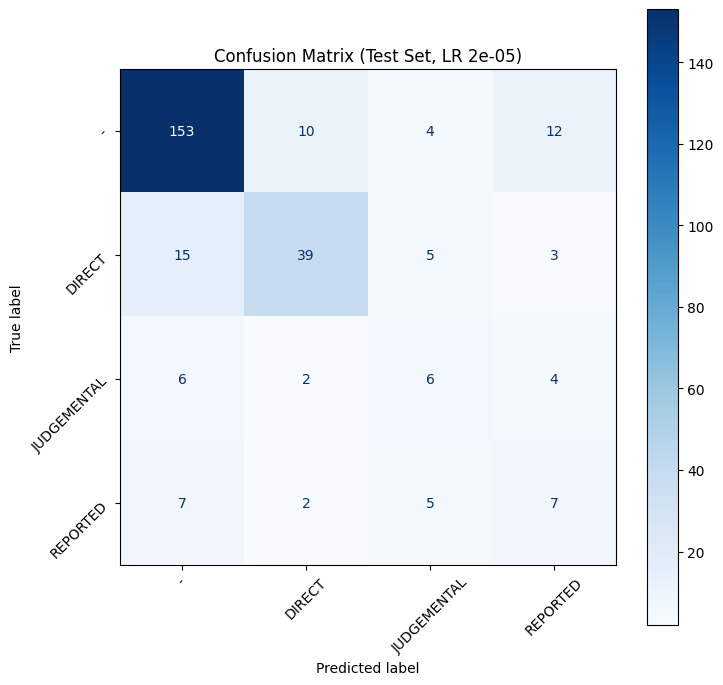

In [ ]:
def display_confusion_matrix(labels, preds)
  cm = confusion_matrix(y_true=labels, y_pred=preds)

  class_labels = list(id2label.values())
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)

  fig, ax = plt.subplots(figsize=(8, 8))
  disp.plot(cmap=plt.cm.Blues, ax=ax, values_format='d')

  ax.set_title(f'Confusion Matrix (Test Set, LR {training_args_lr2e5.learning_rate})')
  plt.xticks(rotation=45)
  plt.yticks(rotation=45)
  plt.show()

display_confusion_matrix(true_labels, preds)

### Plots

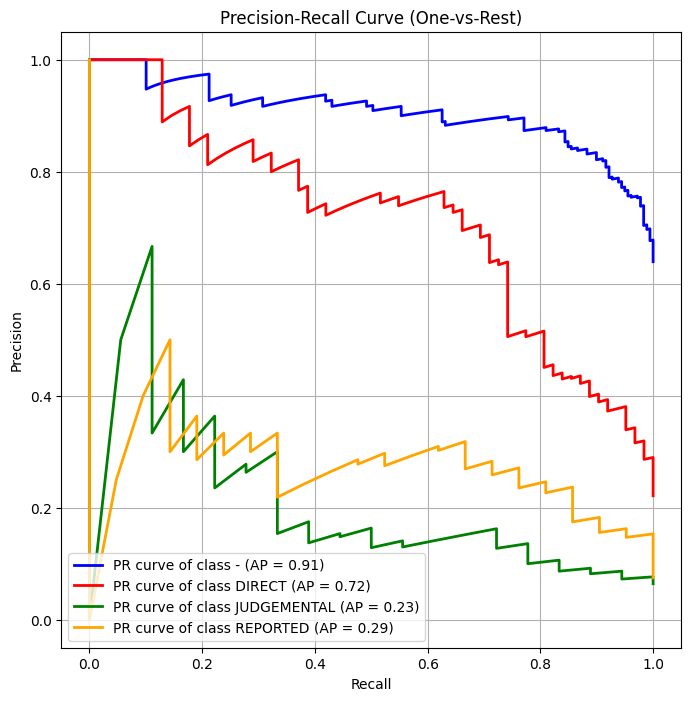

In [ ]:
def pr_curve(labels, probabilities):
  plt.figure(figsize=(8, 8))
  colors = cycle(['blue', 'red', 'green', 'orange'])
  class_labels = ['-', 'DIRECT', 'JUDGEMENTAL', 'REPORTED']

  for i, color in zip(range(4), colors):
      binary_labels = (labels == i)
      precision, recall, _ = precision_recall_curve(binary_labels, probabilities[:, i])

      ap = average_precision_score(binary_labels, probabilities[:, i])

      plt.plot(recall, precision, color=color, lw=2,
              label=f'PR curve of class {class_labels[i]} (AP = {ap:.2f})')

  plt.xlabel("Recall")
  plt.ylabel("Precision")
  plt.title("Precision-Recall Curve (One-vs-Rest)")
  plt.legend(loc="lower left")
  plt.grid(True)
  plt.show()

pr_curve(true_labels, probs)

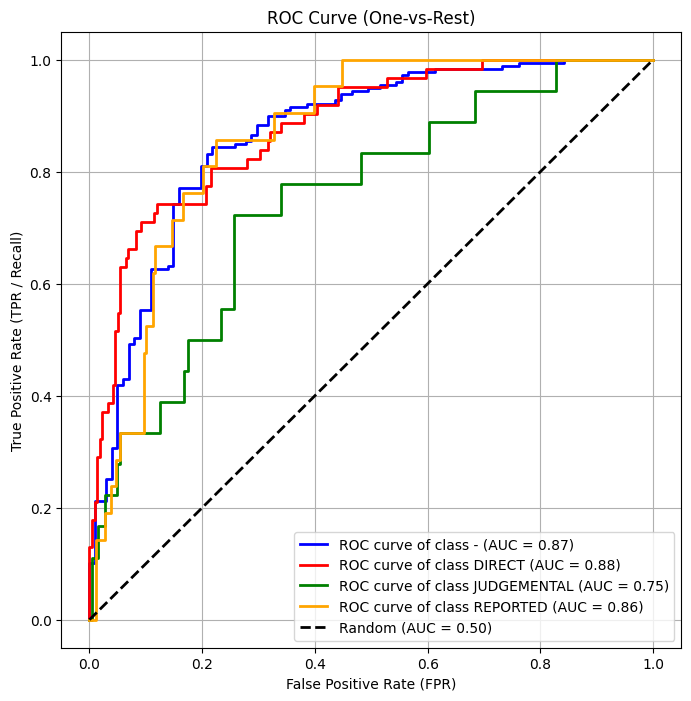

In [ ]:
def plot_roc_curve(labels, probabilities):
  plt.figure(figsize=(8, 8))
  colors = cycle(['blue', 'red', 'green', 'orange'])
  class_labels = ['-', 'DIRECT', 'JUDGEMENTAL', 'REPORTED']

  for i, color in zip(range(4), colors):
      binary_labels = (labels == i)

      # Compute True Positive Rate (TPR) and False Positive Rate (FPR)
      fpr, tpr, _ = roc_curve(binary_labels, probabilities[:, i])

      # Compute Area Under Curve
      roc_auc = auc(fpr, tpr)

      plt.plot(fpr, tpr, color=color, lw=2,
              label=f'ROC curve of class {class_labels[i]} (AUC = {roc_auc:.2f})')

  # Random classifier plot (AUC = 0.5)
  plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random (AUC = 0.50)')

  plt.xlabel("False Positive Rate (FPR)")
  plt.ylabel("True Positive Rate (TPR / Recall)")
  plt.title("ROC Curve (One-vs-Rest)")
  plt.legend(loc="lower right")
  plt.grid(True)
  plt.show()

plot_roc_curve(true_labels, probs)

### Try different model: DeBERTa-v3-small

Made by Microsoft

#### Load model

In [76]:
MODEL = "microsoft/deberta-v3-base"

print(f"Loading: {MODEL}")
tokenizer = AutoTokenizer.from_pretrained(MODEL, use_fast=False)


Loading: microsoft/deberta-v3-base


#### Load tokenizer and tokenization

In [77]:
tokenizer = AutoTokenizer.from_pretrained(MODEL)

In [78]:
def preprocess_text(texts):
    return tokenizer(texts['tweet'], truncation=False)

train_data = train_data.map(preprocess_text, batched=True)
test_data = test_data.map(preprocess_text, batched=True)
val_data = val_data.map(preprocess_text, batched=True)

Map:   0%|          | 0/8056 [00:00<?, ? examples/s]

Map:   0%|          | 0/280 [00:00<?, ? examples/s]

Map:   0%|          | 0/150 [00:00<?, ? examples/s]

In [79]:
for name, token in tokenizer.special_tokens_map.items():
    print(f"{name}: {token} -> id {tokenizer.convert_tokens_to_ids(token)}")

bos_token: [CLS] -> id 1
eos_token: [SEP] -> id 2
unk_token: [UNK] -> id 3
sep_token: [SEP] -> id 2
pad_token: [PAD] -> id 0
cls_token: [CLS] -> id 1
mask_token: [MASK] -> id 128000


In [83]:
show_tokenization_examples(
    dataset=train_data,
    tokenizer=AutoTokenizer.from_pretrained(MODEL)
)

=== Example 5238 ===
Original text:
@user Lol yes and I remember an episode of Night Court where Dan was turned back into a kid and asked a woman if she wanted to play with his *Lincoln log" to funny! 😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂

Decoded text from tokenizer:
[CLS] @user Lol yes and I remember an episode of Night Court where Dan was turned back into a kid and asked a woman if she wanted to play with his *Lincoln log" to funny! 😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂[SEP]
--------------------------------------------------
=== Example 912 ===
Original text:
@user Didnt biden's strike kill women and children?

Decoded text from tokenizer:
[CLS] @user Didnt biden's strike kill women and children?[SEP]
--------------------------------------------------


#### Create model

In [85]:
# format input data to be fed as mini-batches: pad each tweet based on the longest tweet in the mini-batch
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


config = AutoConfig.from_pretrained(
    MODEL,
    num_labels=4,
    id2label=id2label,
    label2id=label2id
)

model_deberta = AutoModelForSequenceClassification.from_pretrained(
    MODEL,
    config=config,
    ignore_mismatched_sizes=True
)

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [86]:
print(model_deberta)

DebertaV2ForSequenceClassification(
  (deberta): DebertaV2Model(
    (embeddings): DebertaV2Embeddings(
      (word_embeddings): Embedding(128100, 768, padding_idx=0)
      (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): DebertaV2Encoder(
      (layer): ModuleList(
        (0-11): 12 x DebertaV2Layer(
          (attention): DebertaV2Attention(
            (self): DisentangledSelfAttention(
              (query_proj): Linear(in_features=768, out_features=768, bias=True)
              (key_proj): Linear(in_features=768, out_features=768, bias=True)
              (value_proj): Linear(in_features=768, out_features=768, bias=True)
              (pos_dropout): Dropout(p=0.1, inplace=False)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): DebertaV2SelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): Layer

#### Train model

In [87]:
# try with lr=2e-5

training_args_deberta_lr2e5 = TrainingArguments(
    output_dir="val_dir/trainer_deberta",             # where to save model
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,     # defines distributed training
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epochs,
    weight_decay=0.01,
    eval_strategy="epoch",             # when to report evaluation metrics/losses
    save_strategy="epoch",             # when to save checkpoint
    logging_strategy="epoch",
    load_best_model_at_end=True,
    report_to='none',
    metric_for_best_model="f1",
    greater_is_better=True,
    warmup_ratio=0.1
)

In [88]:
best_state_deberta, best_seed_deberta = train_evaluate_over_seeds(
    seeds=seeds,
    model_name=MODEL,
    base_training_args=training_args_deberta_lr2e5,
    train_data=train_data,
    val_data=val_data,
    test_data=test_data,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics_HF,
    id2label=id2label,
    label2id=label2id,
    fix_seed_fn=fix_seed,
    output_dir_root="./results/deberta_lr_2e5",
    csv_output_name="deberta_seed_results_lr_2e5.csv",
    model_output_name="best_deberta_model_lr2e5.pt"
)


 Running with seed: 42



Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 2, 'bos_token_id': 1}.


Epoch,Training Loss,Validation Loss,F1,Accuracy
1,1.098700,0.941474,0.465229,0.660000
2,0.262700,1.465863,0.558275,0.686667


KeyboardInterrupt: 

## Task 7 - Error Analysis

### BiLSTM

### RoBERTa
As we can clearly see from the Precision-Recall (PR) Curve and the ROC Curve, the model **excels** at correctly classifying `neutral` and `direct` tweets.

On the other hand, the model demonstrates severe struggle with `judgemental` tweets and performs truly poorly when attempting to classify `reported` tweets.

This behavior is not surprising, as the dataset is heavily imbalanced, skewing towards the `neutral` class.

**Detailed Analysis of Poorly Performing Classes:**

* **`Reported` tweets:** The combination of a low Average Precision ($\text{AP}=0.29$) and a relatively high Area Under the Curve ($\text{AUC}=0.86$) suggests a textbook case of **extreme class imbalance**. The high AUC indicates the model is conceptually able to rank the confidence scores correctly, but since the class is rare, even a small number of **False Positives** overwhelm the few existing **True Positives**, leading to a drastic drop in Precision and, consequently, a low AP score.
* **`Judgemental` tweets:** This is the worst-performing class ($\text{AP}=0.23$ - $\text{AUC}=0.75$). The fact that the AUC is the lowest suggests that the issue is not *only* imbalance but also **semantic ambiguity**. The textual boundaries of the `Judgemental` class are likely blurred with other classes, making it difficult for the model to reliably separate it, resulting in poor confidence scores overall.

### Analysis of the Confusion Matrix

Moreover, as we can see from the **Confusion Matrix**, the model is overall good at determining the correct class.

The key findings from the confusion matrix regarding misclassification are:

1.  **Absorption of Minorities (Key Error Type):** The vast majority of **False Negatives** for the minority classes (`Judgemental` and `Reported`) are misclassified as **`Neutral`** or **`Direct`** (the majority classes). This confirms the model's tendency to favor the dominant label, a direct consequence of the data imbalance.
2.  **Ambiguity between Major Classes:** While the main error is related to minority classes, the most confused classes in **absolute count** are **`Neutral`** and **`Direct`**. This suggests that these two classes, despite being well-represented, share similar linguistic patterns that the model finds difficult to disambiguate cleanly.

Overall, the primary focus for improvement must be on **mitigating data imbalance** for `Reported` and resolving the **semantic ambiguity** for `Judgemental`.


### RoBERTa vs BiLSTM
Of course, as expected, RoBERTa outperforms BiLSTM, with an F1-score = $0.5355$ against the BiLSTM F1-score = **?????**

<Axes: xlabel='label', ylabel='count'>

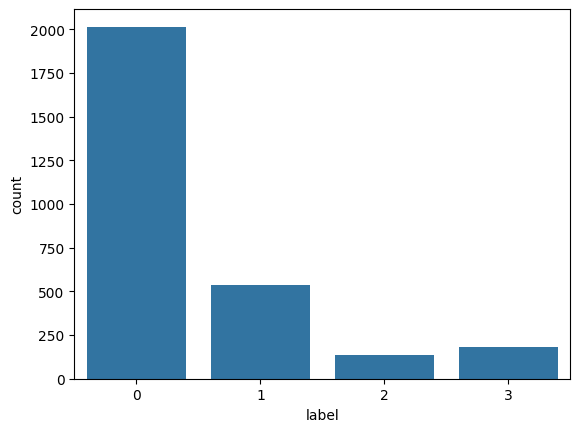

In [34]:
# show unbalance dataset
sns.countplot(data=train_df_np, x='label')

In [18]:
from sklearn.utils import resample

def oversample_multiclass(df, target_col='label', random_state=101):
    """Balance a multi-class dataset by oversampling minority classes."""
    max_size = df[target_col].value_counts().max()

    oversampled_parts = [
        resample(df[df[target_col] == label],
                 replace=True,
                 n_samples=max_size,
                 random_state=random_state)
        for label in df[target_col].unique()
    ]

    df_oversampled = pd.concat(oversampled_parts)
    return df_oversampled.sample(frac=1, random_state=random_state).reset_index(drop=True)

In [35]:
balanced_train_df_np = oversample_multiclass(train_df_np)

<Axes: xlabel='label', ylabel='count'>

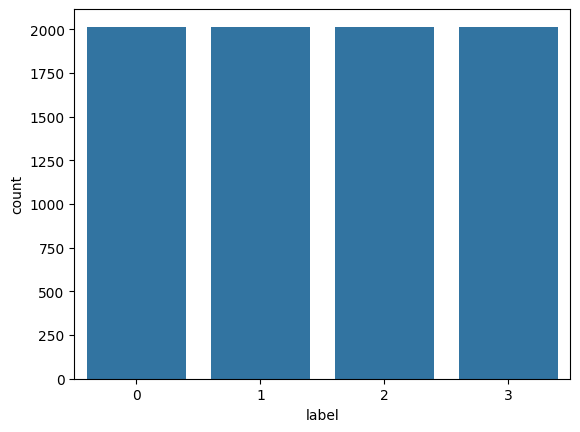

In [58]:
sns.countplot(data=balanced_train_df_np, x='label')

### Re-try Task 3 - Task 6

Now, we will train again our models (from task 3 and task 6) using a balanced dataset, to see if there are any differences.

#### Task 3 - part2

#### Task 6 - part2

In [59]:
train_data = Dataset.from_pandas(balanced_train_df_np)
val_data = Dataset.from_pandas(val_df_np)
test_data = Dataset.from_pandas(test_df_np)

In [60]:
train_data = train_data.map(preprocess_batch, batched=True)
val_data = val_data.map(preprocess_batch, batched=True)
test_data = test_data.map(preprocess_batch, batched=True)

Map:   0%|          | 0/8056 [00:00<?, ? examples/s]

Map:   0%|          | 0/150 [00:00<?, ? examples/s]

Map:   0%|          | 0/280 [00:00<?, ? examples/s]

In [61]:
train_data = train_data.map(preprocess_text, batched=True)
test_data = test_data.map(preprocess_text, batched=True)
val_data = val_data.map(preprocess_text, batched=True)

Map:   0%|          | 0/8056 [00:00<?, ? examples/s]

Map:   0%|          | 0/280 [00:00<?, ? examples/s]

Map:   0%|          | 0/150 [00:00<?, ? examples/s]

In [71]:
best_state_balanced, best_seed_balanced = train_evaluate_over_seeds(
    seeds=[best_seed],
    model_name=MODEL,
    base_training_args=training_args_lr2e5,
    train_data=train_data,
    val_data=val_data,
    test_data=test_data,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics_HF,
    id2label=id2label,
    label2id=label2id,
    fix_seed_fn=fix_seed,
    output_dir_root="./results/lr_2e5_balanced",
    csv_output_name="roberta_seed_results_lr_2e5_balanced.csv",
    model_output_name="best_roberta_model_lr2e5_balanced.pt"
)


 Running with seed: 12



Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-hate and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([2, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([2]) in the checkpoint and torch.Size([4]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 

In [ ]:
# define model for inference
fix_seed(best_seed_balanced)

config = AutoConfig.from_pretrained(
        MODEL, num_labels=4, id2label=id2label, label2id=label2id
    )

best_model = AutoModelForSequenceClassification.from_pretrained(
    MODEL, config=config, ignore_mismatched_sizes=True
)
best_model.load_state_dict(best_state_balanced)

prediction_args = TrainingArguments(
    output_dir="./prediction_output",
    per_device_eval_batch_size=batch_size,
    eval_strategy="no",
    save_strategy="no",
    report_to='none',
)

inference_trainer = Trainer(
    model=best_model,
    args=prediction_args,
    data_collator=data_collator,
    compute_metrics=compute_metrics_HF
)

In [ ]:
preds, true_labels, probs = predict_and_sample(
    trainer=inference_trainer,
    test_data=test_data,
    tokenizer=tokenizer,
    id2label=id2label,
    num_samples=10,
    ignore_class_id=0  # Skips class 0 (Neutral)
)

In [ ]:
display_confusion_matrix(true_labels, preds)

In [ ]:
pr_curve(true_labels, probs)

In [ ]:
plot_roc_curve(true_labels, probs)